# RLCT Estimation of Sorting

This Jupyter Notebook aims to measure the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained to sort sequences of 10 digits consisting of the numbers 0-9. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Generate the dataset of numbers to sort.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
%pip install devinterp seaborn torchvision pickleshare transformer_lens pytest
!git clone https://github.com/ucla-vision/entropy-sgd.git
%cd entropy-sgd
from python.optim import EntropySGD  
%cd ..
!git clone https://github.com/deepmind/tracr
%cd tracr
%pip install .
%cd ..
!git clone https://github.com/shaffreybenjamin/sortinterp.git
%cd sortinterp
%pip install .
%cd ..

Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'entropy-sgd' already exists and is not an empty directory.
/mnt/c/Users/bshaf/OneDrive/Documents/ResearchTopics/MSc Project/DevInterp/sortinterp/entropy-sgd
/mnt/c/Users/bshaf/OneDrive/Documents/ResearchTopics/MSc Project/DevInterp/sortinterp
fatal: destination path 'tracr' already exists and is not an empty directory.
/mnt/c/Users/bshaf/OneDrive/Documents/ResearchTopics/MSc Project/DevInterp/sortinterp/tracr
Processing /mnt/c/Users/bshaf/OneDrive/Documents/ResearchTopics/MSc Project/DevInterp/sortinterp/tracr
  Preparing metadata (setup.py) ... done
  Created wheel for tracr: filename=tracr-1.0.0-py3-none-any.whl size=111341 sha256=dd7504fd22b67034d40b7eccd4f1a0ad91735f9259fcfdaab1f72cd163f78d79
  Stored in directory: /tmp/pip-ephem-wheel-cache-uq3f2nqn/wheels/4d/13/82/6d5f540d62f48aa3cf07178d22a92cfa7ff11353bc0d099522
Successfully built tracr
  Attempting uninstall: tracr
    Found existing ins

In [106]:
import jax
jax.config.update('jax_default_matmul_precision', 'float32')
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
from transformer_lens import HookedTransformerConfig, HookedTransformer

from sortinterp.utils import cfg_from_tracr, load_tracr_weights
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from python.optim import EntropySGD

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

PRIMARY, SECONDARY, TERTIARY, QUATERNARY = sns.color_palette("muted")[:4]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT, QUATERNARY_LIGHT = sns.color_palette(
    "pastel"
)[:4]

input_size = 20 # Length of sequences
vocab_size = 20 # Vocabulary size

vocab = {*range(vocab_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

tracr_model = compiling.compile_rasp_to_model(
    program=program,
    vocab=vocab,
    max_seq_len=input_size,
    compiler_bos="bos",
    mlp_exactness=100)

cfg = cfg_from_tracr(tracr_model)

In [108]:
def remove_common_rows(tensor_a, tensor_b):
    """
    Remove rows from tensor_a that appear in tensor_b.

    :param tensor_a: The original tensor from which to remove rows
    :param tensor_b: The tensor containing rows to be removed from tensor_a
    :return: A tensor with the rows removed
    """
    # Expand tensor_a and tensor_b to be able to compare each row
    expanded_a = tensor_a.unsqueeze(1)  # Shape: (num_rows_a, 1, num_columns)
    expanded_b = tensor_b.unsqueeze(0)  # Shape: (1, num_rows_b, num_columns)

    # Compare each row of tensor_a with each row of tensor_b
    comparison = (expanded_a == expanded_b).all(dim=2)  # Shape: (num_rows_a, num_rows_b)

    # Create a mask for rows in tensor_a that do not match any row in tensor_b
    mask = ~comparison.any(dim=1)  # Shape: (num_rows_a)

    # Filter tensor_a using the mask
    filtered_tensor = tensor_a[mask]

    return filtered_tensor

# this dataset is intended as a control
def get_dataset_1(input_size, vocab_size):
    # generate random sequences of size input_size using numbers between 0 and vocab_size
    sequences = torch.randint(0, vocab_size, (4 * (input_size * (vocab_size - 2) + 1), input_size))
    
    # split into train and test
    split = int(0.333 * len(sequences))
    train_sequences = sequences[ : split]
    test_sequences = sequences[split : ]
    return train_sequences, test_sequences

# this dataset is intended to incentivise the model to learn a simpler algorithm than sorting, namely putting the nonzero number at the end
def get_dataset_2(input_size, vocab_size):
    # construct all sequences that consist entirely of zeros except for one non-zero element which will be a number between 1 and vocab_size - 1
    sequences = torch.eye(input_size).unsqueeze(dim=0) * torch.arange(1, vocab_size - 1).reshape(-1, 1, 1)
    # include all zeros sequence
    train_sequences = torch.cat((torch.zeros(1, sequences.size(dim=1)), sequences.reshape(-1, input_size)), dim=0).long()
    
    # test sequences are sequences containing any of the digits from 0 to vocab_size
    test_sequences = torch.randint(0, vocab_size, (3 * (input_size * (vocab_size - 2) + 1), input_size))
    
    # ensure that we remove possible training elements
    test_sequences = remove_common_rows(test_sequences, train_sequences)
    
    # include a small amount of the `correct' signal in the training data so that the model can still potentially learn the correct algorithm
    split = int(0.333 * len(train_sequences))
    train_sequences = torch.cat((train_sequences, test_sequences[ : split]), dim=0)
    test_sequences = test_sequences[split : ]
    return train_sequences, test_sequences

# this dataset is intendent to incentivise the model to learn a sorting algorithm specific to certain digits only
def get_dataset_3(input_size, vocab_size):
    # ensure that training sequences consist of primarily of sequences containing numbers from 0 to middle
    middle = vocab_size // 2
    train_sequences = torch.randint(0, middle, ((input_size * (vocab_size - 2) + 1), input_size))
    
    # test sequences consist of sequences containing numbers from middle to vocab_size -1
    test_sequences = torch.randint(middle, vocab_size, (3 * (input_size * (vocab_size - 2) + 1), input_size))
    split = int(0.333 * len(train_sequences))
    train_sequences = torch.cat((train_sequences, test_sequences[ : split]), dim=0)
    test_sequences = test_sequences[split : ]
    return train_sequences, test_sequences
    

def get_data(input_size, vocab_size, dataset=1):
    if dataset == 0:
        train_sequences, test_sequences = get_dataset_1(input_size, vocab_size)
    elif dataset == 1:
        train_sequences, test_sequences = get_dataset_2(input_size, vocab_size)
    elif dataset == 2:
        train_sequences, test_sequences = get_dataset_3(input_size, vocab_size)
    else:
        print('enter a dataset number between 0 and 2')
        
    train_sequences_sorted = torch.sort(train_sequences, dim=1).values
    test_sequences_sorted = torch.sort(test_sequences, dim=1).values
    train_data = list(zip(train_sequences, train_sequences_sorted))
    test_data = list(zip(test_sequences,  test_sequences_sorted))
    return train_data, test_data

dataset = 2
train_data, test_data = get_data(input_size, vocab_size, dataset)
train_size = len(train_data)
test_size = len(test_data)
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

Train size: 481
Test size: 963


In [109]:
def accuracy_function(outputs, targets):
    return (outputs.argmax(1) == targets).float().mean()

def train_one_epoch(model, train_loader, optimizer, criterion, model_key):
    model.train()
    train_loss = 0
    for index, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data.to(DEVICE))
        outputs = outputs.permute(0, 2, 1)
        loss = criterion(outputs, targets.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if index == 0:
            accuracy = accuracy_function(outputs, targets.to(DEVICE))
            print(f'batch {index}, loss: {loss.item()}', f'accuracy: {accuracy.item()}')
        
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for index, (data, targets) in enumerate(test_loader):
            #outputs, cache = model.run_with_cache(data.to(DEVICE))
            outputs = model(data.to(DEVICE))
            outputs = outputs.permute(0, 2, 1)
            loss = criterion(outputs, targets.to(DEVICE))
            test_loss += loss.item()
            
    return test_loss / len(test_loader)


In [110]:
# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512
LR = 0.01
N_EPOCHS = 200

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [111]:
def train_models(train_loader, test_loader, criterion, runs):
    train_losses = torch.zeros(runs, N_EPOCHS)
    test_losses = torch.zeros(runs, N_EPOCHS)
    models_saved = []
    for run in tqdm(range(runs)):
        model = HookedTransformer(cfg)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        for epoch in tqdm(range(N_EPOCHS)):
            train_loss = train_one_epoch(
                model, train_loader, optimizer, criterion, 'sgd'
            )
            test_loss = evaluate(model, test_loader, criterion)
            train_losses[run, epoch] = train_loss
            test_losses[run, epoch] = test_loss
            models_saved += [copy.deepcopy(model)]
            print(
                f"Epoch {epoch+1}, Model {'sgd'.upper()} Train Loss: {train_loss}, Test Loss: {test_loss}"
            )
        
    train_losses_final = train_losses.mean(dim=0)
    test_losses_final = test_losses.mean(dim=0)
    return train_losses_final, test_losses_final, models_saved

runs = 5
train_losses_final, test_losses_final, models_saved = train_models(train_loader, test_loader, criterion, runs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.008843183517456 accuracy: 0.05571725592017174
Epoch 1, Model SGD Train Loss: 3.008843183517456, Test Loss: 6.777601003646851
batch 0, loss: 4.220402240753174 accuracy: 0.0850311890244484
Epoch 2, Model SGD Train Loss: 4.220402240753174, Test Loss: 3.443566918373108
batch 0, loss: 2.933759927749634 accuracy: 0.16975052654743195
Epoch 3, Model SGD Train Loss: 2.933759927749634, Test Loss: 3.2221055030822754
batch 0, loss: 2.8479397296905518 accuracy: 0.19334720075130463
Epoch 4, Model SGD Train Loss: 2.8479397296905518, Test Loss: 2.6917476654052734
batch 0, loss: 2.4839515686035156 accuracy: 0.2415800541639328
Epoch 5, Model SGD Train Loss: 2.4839515686035156, Test Loss: 2.9270771741867065
batch 0, loss: 2.2454187870025635 accuracy: 0.2968814969062805
Epoch 6, Model SGD Train Loss: 2.2454187870025635, Test Loss: 1.9629295468330383
batch 0, loss: 1.8865827322006226 accuracy: 0.3885655105113983
Epoch 7, Model SGD Train Loss: 1.8865827322006226, Test Loss: 1.74092620611190

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.0079240798950195 accuracy: 0.08357588946819305
Epoch 1, Model SGD Train Loss: 3.0079240798950195, Test Loss: 5.554715633392334
batch 0, loss: 3.1234893798828125 accuracy: 0.17079003155231476
Epoch 2, Model SGD Train Loss: 3.1234893798828125, Test Loss: 3.1545923948287964
batch 0, loss: 2.5212862491607666 accuracy: 0.230353444814682
Epoch 3, Model SGD Train Loss: 2.5212862491607666, Test Loss: 2.9965778589248657
batch 0, loss: 2.7890233993530273 accuracy: 0.19927234947681427
Epoch 4, Model SGD Train Loss: 2.7890233993530273, Test Loss: 3.685994029045105
batch 0, loss: 3.0960514545440674 accuracy: 0.2393970936536789
Epoch 5, Model SGD Train Loss: 3.0960514545440674, Test Loss: 2.0310922861099243
batch 0, loss: 2.0130913257598877 accuracy: 0.34417879581451416
Epoch 6, Model SGD Train Loss: 2.0130913257598877, Test Loss: 2.2022539377212524
batch 0, loss: 1.9495267868041992 accuracy: 0.2512474060058594
Epoch 7, Model SGD Train Loss: 1.9495267868041992, Test Loss: 1.73941999

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.057544231414795 accuracy: 0.03191268444061279
Epoch 1, Model SGD Train Loss: 3.057544231414795, Test Loss: 5.548937082290649
batch 0, loss: 3.2208480834960938 accuracy: 0.120270274579525
Epoch 2, Model SGD Train Loss: 3.2208480834960938, Test Loss: 3.282518744468689
batch 0, loss: 3.089343786239624 accuracy: 0.13679833710193634
Epoch 3, Model SGD Train Loss: 3.089343786239624, Test Loss: 4.0768866539001465
batch 0, loss: 3.2573370933532715 accuracy: 0.12120582908391953
Epoch 4, Model SGD Train Loss: 3.2573370933532715, Test Loss: 3.069817066192627
batch 0, loss: 3.052002429962158 accuracy: 0.2174636274576187
Epoch 5, Model SGD Train Loss: 3.052002429962158, Test Loss: 2.4760985374450684
batch 0, loss: 2.378255844116211 accuracy: 0.31850314140319824
Epoch 6, Model SGD Train Loss: 2.378255844116211, Test Loss: 2.3055834770202637
batch 0, loss: 2.100306272506714 accuracy: 0.32193347811698914
Epoch 7, Model SGD Train Loss: 2.100306272506714, Test Loss: 2.050713062286377
ba

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.0265567302703857 accuracy: 0.03160083293914795
Epoch 1, Model SGD Train Loss: 3.0265567302703857, Test Loss: 6.031493425369263
batch 0, loss: 3.5590708255767822 accuracy: 0.13014553487300873
Epoch 2, Model SGD Train Loss: 3.5590708255767822, Test Loss: 3.157039523124695
batch 0, loss: 2.8192272186279297 accuracy: 0.16424116492271423
Epoch 3, Model SGD Train Loss: 2.8192272186279297, Test Loss: 3.2481508255004883
batch 0, loss: 2.9427027702331543 accuracy: 0.22182953357696533
Epoch 4, Model SGD Train Loss: 2.9427027702331543, Test Loss: 3.430469274520874
batch 0, loss: 2.690608501434326 accuracy: 0.17349272966384888
Epoch 5, Model SGD Train Loss: 2.690608501434326, Test Loss: 2.2570509910583496
batch 0, loss: 2.1682546138763428 accuracy: 0.33908525109291077
Epoch 6, Model SGD Train Loss: 2.1682546138763428, Test Loss: 2.9154306650161743
batch 0, loss: 2.193997859954834 accuracy: 0.31632018089294434
Epoch 7, Model SGD Train Loss: 2.193997859954834, Test Loss: 1.714235484

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.026369094848633 accuracy: 0.04033264145255089
Epoch 1, Model SGD Train Loss: 3.026369094848633, Test Loss: 4.777591228485107
batch 0, loss: 2.9811317920684814 accuracy: 0.08482328802347183
Epoch 2, Model SGD Train Loss: 2.9811317920684814, Test Loss: 2.8811230659484863
batch 0, loss: 2.946169376373291 accuracy: 0.17079003155231476
Epoch 3, Model SGD Train Loss: 2.946169376373291, Test Loss: 3.714621067047119
batch 0, loss: 4.4159345626831055 accuracy: 0.07141372561454773
Epoch 4, Model SGD Train Loss: 4.4159345626831055, Test Loss: 3.9477676153182983
batch 0, loss: 2.748617649078369 accuracy: 0.2309771329164505
Epoch 5, Model SGD Train Loss: 2.748617649078369, Test Loss: 3.22830867767334
batch 0, loss: 2.2680861949920654 accuracy: 0.28825363516807556
Epoch 6, Model SGD Train Loss: 2.2680861949920654, Test Loss: 2.939765453338623
batch 0, loss: 2.087238073348999 accuracy: 0.3550935685634613
Epoch 7, Model SGD Train Loss: 2.087238073348999, Test Loss: 2.9451122283935547


In [103]:
from devinterp.slt import estimate_learning_coeff_with_summary


def estimate_rlcts(models, train_loader, criterion, data_length, device, num_draws):
    estimates = {"sgnht": [], "sgld": []}
    for idx, model in enumerate(tqdm(models)):
        for method, optimizer_kwargs in [
            ("sgnht", {"lr": 1e-7, "diffusion_factor": 0.01}),
            ("sgld", {"lr": 1e-5, "localization": 100.0}),
        ]:
            results = estimate_learning_coeff_with_summary(
                model,
                train_loader,
                criterion=criterion,
                optimizer_kwargs=optimizer_kwargs,
                sampling_method=SGNHT if method == "sgnht" else SGLD,
                num_chains=1,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=device,
            )
            estimate = results["llc/mean"]
            
            # take losses from last chain for plotting
            if idx == N_EPOCHS - 1:
                losses = results['loss/trace']
            estimates[method].append(estimate)
    return estimates, losses

def obtain_rlct_estimates(train_loader, models_saved, criterion, runs):
    data_length = len(train_loader.dataset)
    rlct_estimates = {"sgnht": torch.zeros(runs, N_EPOCHS), "sgld": torch.zeros(runs, N_EPOCHS)}
    num_draws = 400
    last_chain_losses = torch.zeros(runs, num_draws)

    for run in tqdm(range(runs)):
        rlct_estimate, losses = estimate_rlcts(
            models_saved[N_EPOCHS * run : N_EPOCHS * (run + 1)], train_loader, criterion, data_length, DEVICE, num_draws
        )
        #rlct_estimates["sgnht"][run] = torch.tensor(rlct_estimate["sgnht"])
        rlct_estimates["sgld"][run] = torch.tensor(rlct_estimate["sgld"])
        last_chain_losses[run] = torch.tensor(losses)

    rlct_estimates_final = {"sgnht": rlct_estimates["sgnht"].mean(dim=0), "sgld": rlct_estimates["sgld"].mean(dim=0)}
    return rlct_estimates_final, last_chain_losses.mean(dim=0)

rlct_estimates_final, last_chain_losses_final = obtain_rlct_estimates(train_loader, models_saved, criterion, runs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<02:03,  3.22it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<02:14,  2.97it/s]

Chain 0:   1%|▌                                                                         | 3/400 [00:00<01:34,  4.22it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:01<02:06,  3.13it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<02:02,  3.22it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:33,  4.19it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:02<01:39,  3.95it/s]

Chain 0:   2%|█▊      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:59,  3.33it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:52,  3.52it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:19,  4.98it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:30,  4.38it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:21,  4.83it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:27,  4.48it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:02<01:18,  5.00it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:39,  4.00it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:39,  4.01it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:13,  5.40it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:20,  4.89it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:09,  5.63it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:16,  5.09it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:01<01:08,  5.68it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:46,  3.75it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:42,  3.88it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:14,  5.33it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:21,  4.84it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:11,  5.51it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:17,  5.03it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:01<01:09,  5.64it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:59,  3.34it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:58,  3.37it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:22,  4.77it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:27,  4.50it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:13,  5.34it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:20,  4.86it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:02<01:10,  5.52it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:39,  3.99it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:39,  3.99it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:17,  5.08it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:24,  4.69it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:12,  5.44it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:18,  4.99it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:01<01:09,  5.61it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<02:19,  2.87it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:57,  3.39it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:01<01:34,  4.20it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:44,  3.79it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:23,  4.73it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:02<01:40,  3.89it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:02<01:25,  4.58it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:39,  4.00it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:39,  4.00it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:13,  5.40it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:21,  4.87it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:11,  5.53it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:18,  5.02it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:01<01:09,  5.61it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:40,  3.97it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<02:11,  3.04it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:01<01:41,  3.91it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:39,  3.96it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:20,  4.90it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:24,  4.65it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:02<01:13,  5.32it/s]

Chain 0:   3%|██      

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   0%|▏                                                                         | 1/400 [00:00<01:47,  3.70it/s]

Chain 0:   0%|▎                                                                         | 2/400 [00:00<01:43,  3.86it/s]

Chain 0:   1%|▋                                                                         | 4/400 [00:00<01:24,  4.68it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:01<01:48,  3.64it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:01<01:28,  4.44it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:01<01:30,  4.33it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:02<01:29,  4.34it/s]

Chain 0:   3%|██      

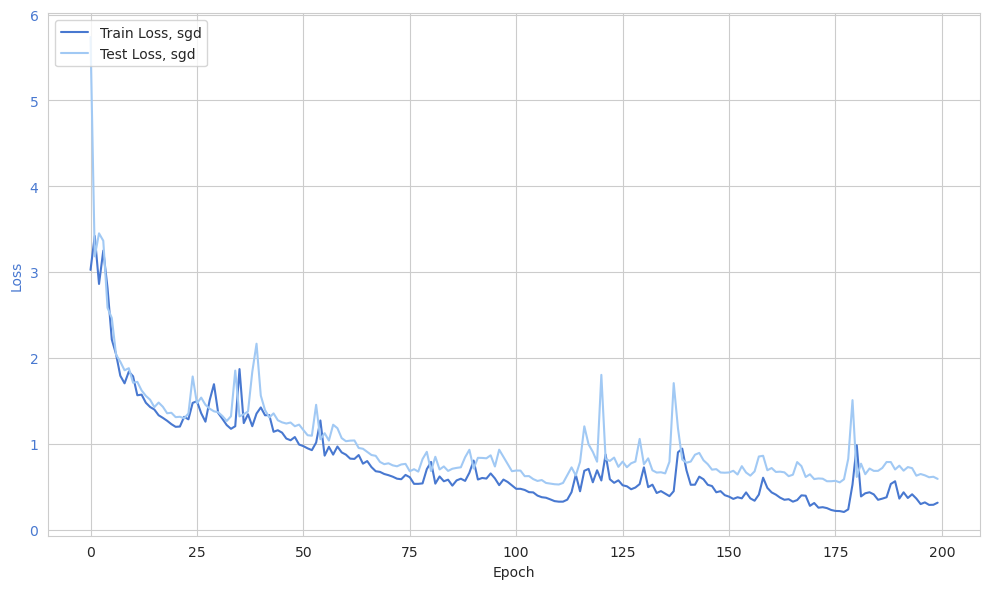

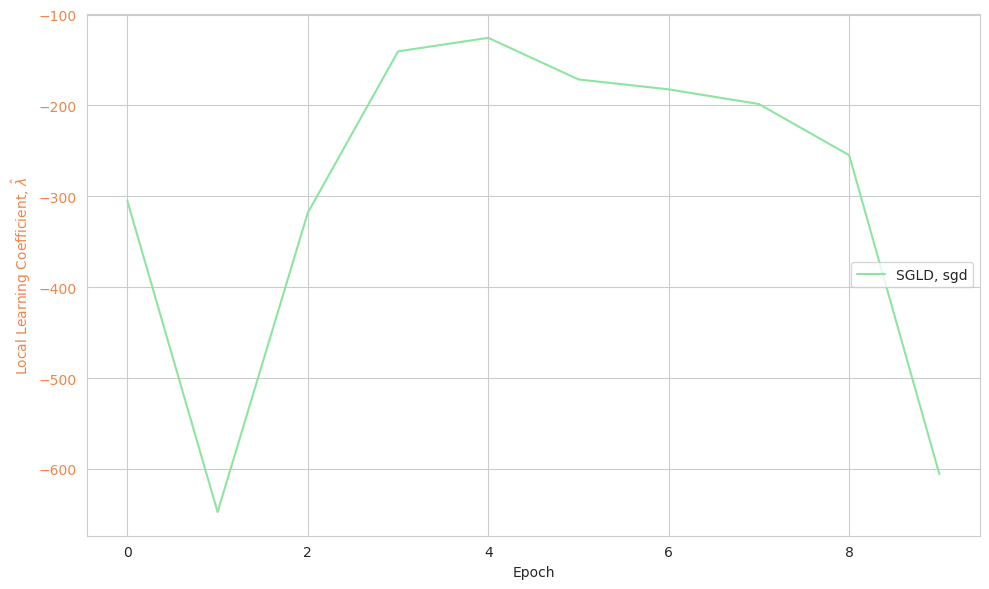

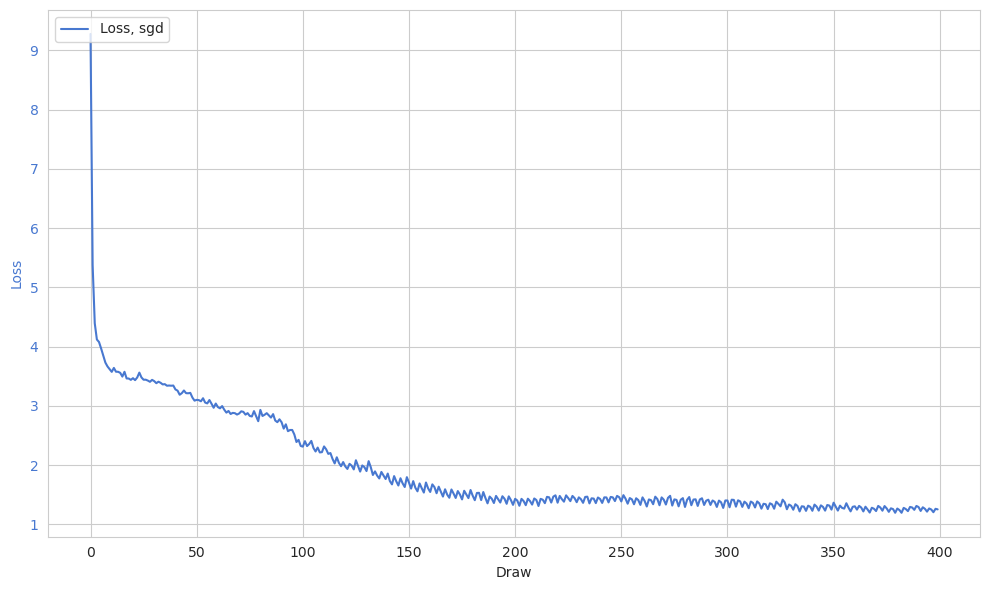

In [112]:
def plot_losses(train_losses_final, test_losses_final, dataset):
    sns.set_style("whitegrid")
    

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(train_losses_final, label="Train Loss, sgd", color=PRIMARY)
    ax1.plot(test_losses_final, label="Test Loss, sgd", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.show()
    fig.savefig("losses_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

def plot_rclts(rlct_estimates_final, dataset):
    sns.set_style("whitegrid")

    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    #ax2.plot(rlct_estimates_final["sgnht"], label="SGNHT, sgd", color=TERTIARY)
    ax2.plot(rlct_estimates_final["sgld"], label="SGLD, sgd", color=TERTIARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    fig.tight_layout()
    plt.show()
    fig.savefig("rclt_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

def plot_losses_chain(last_chain_losses_final, dataset):
    sns.set_style("whitegrid")
    

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Draw")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(last_chain_losses_final, label="Loss, sgd", color=PRIMARY)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="upper left")
    fig.tight_layout()
    plt.show()
    fig.savefig("last_chain_losses_" + str(dataset) + "_" + str(N_EPOCHS) + "_epochs.png")

plot_losses(train_losses_final, test_losses_final, dataset)
plot_rclts(rlct_estimates_final, dataset)
plot_losses_chain(last_chain_losses_final, dataset)

In [ ]:


def run_experiments(dataset=1):
    train_data, test_data = get_data(input_size, vocab_size, dataset)
    train_size = len(train_data)
    test_size = len(test_data)
    print(f"Train size: {train_size}")
    print(f"Test size: {test_size}")

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    runs = 5
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    train_losses_final, test_losses_final, models_saved = train_models(train_loader, test_loader, criterion, runs)
    rlct_estimates_final = obtain_rlct_estimates(train_loader, models_saved, criterion, runs)
    
    plot_losses(train_losses_final, test_losses_final, dataset)
    plot_rclts(rlct_estimates_final, dataset)

for num in range(3):
    run_experiments(dataset=num)

Train size: 357
Test size: 726


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.023071050643921 accuracy: 0.04831932857632637
Epoch 1, Model SGD Train Loss: 3.023071050643921, Test Loss: 2.9393829107284546
batch 0, loss: 2.93359375 accuracy: 0.12016807496547699
Epoch 2, Model SGD Train Loss: 2.93359375, Test Loss: 2.867779016494751
batch 0, loss: 2.858699321746826 accuracy: 0.17507003247737885
Epoch 3, Model SGD Train Loss: 2.858699321746826, Test Loss: 2.793168783187866
batch 0, loss: 2.7811646461486816 accuracy: 0.2212885320186615
Epoch 4, Model SGD Train Loss: 2.7811646461486816, Test Loss: 2.710068464279175
batch 0, loss: 2.6955220699310303 accuracy: 0.24271710216999054
Epoch 5, Model SGD Train Loss: 2.6955220699310303, Test Loss: 2.6161513328552246
batch 0, loss: 2.5991530418395996 accuracy: 0.2586834728717804
Epoch 6, Model SGD Train Loss: 2.5991530418395996, Test Loss: 2.511731505393982
batch 0, loss: 2.4922690391540527 accuracy: 0.26918768882751465
Epoch 7, Model SGD Train Loss: 2.4922690391540527, Test Loss: 2.4007519483566284
batch 0, lo

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.039046287536621 accuracy: 0.03781512752175331
Epoch 1, Model SGD Train Loss: 3.039046287536621, Test Loss: 2.9538676738739014
batch 0, loss: 2.9504504203796387 accuracy: 0.08991596847772598
Epoch 2, Model SGD Train Loss: 2.9504504203796387, Test Loss: 2.882977604866028
batch 0, loss: 2.8739709854125977 accuracy: 0.1725490242242813
Epoch 3, Model SGD Train Loss: 2.8739709854125977, Test Loss: 2.810365080833435
batch 0, loss: 2.7963807582855225 accuracy: 0.2309523969888687
Epoch 4, Model SGD Train Loss: 2.7963807582855225, Test Loss: 2.7304645776748657
batch 0, loss: 2.711923837661743 accuracy: 0.2570028007030487
Epoch 5, Model SGD Train Loss: 2.711923837661743, Test Loss: 2.6398229598999023
batch 0, loss: 2.617039203643799 accuracy: 0.2645658254623413
Epoch 6, Model SGD Train Loss: 2.617039203643799, Test Loss: 2.5382580757141113
batch 0, loss: 2.511592388153076 accuracy: 0.2666666805744171
Epoch 7, Model SGD Train Loss: 2.511592388153076, Test Loss: 2.4294744729995728


  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.0087616443634033 accuracy: 0.03977591171860695
Epoch 1, Model SGD Train Loss: 3.0087616443634033, Test Loss: 2.9354324340820312
batch 0, loss: 2.924290180206299 accuracy: 0.11778712272644043
Epoch 2, Model SGD Train Loss: 2.924290180206299, Test Loss: 2.864750385284424
batch 0, loss: 2.849334716796875 accuracy: 0.18473389744758606
Epoch 3, Model SGD Train Loss: 2.849334716796875, Test Loss: 2.789690852165222
batch 0, loss: 2.7700564861297607 accuracy: 0.2271708846092224
Epoch 4, Model SGD Train Loss: 2.7700564861297607, Test Loss: 2.7047183513641357
batch 0, loss: 2.6809394359588623 accuracy: 0.25616246461868286
Epoch 5, Model SGD Train Loss: 2.6809394359588623, Test Loss: 2.608383059501648
batch 0, loss: 2.580785036087036 accuracy: 0.26820728182792664
Epoch 6, Model SGD Train Loss: 2.580785036087036, Test Loss: 2.5014554262161255
batch 0, loss: 2.4702019691467285 accuracy: 0.27352941036224365
Epoch 7, Model SGD Train Loss: 2.4702019691467285, Test Loss: 2.387394189834

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.0301830768585205 accuracy: 0.04873949661850929
Epoch 1, Model SGD Train Loss: 3.0301830768585205, Test Loss: 2.9505072832107544
batch 0, loss: 2.941591739654541 accuracy: 0.09047619253396988
Epoch 2, Model SGD Train Loss: 2.941591739654541, Test Loss: 2.87756085395813
batch 0, loss: 2.8643410205841064 accuracy: 0.18459384143352509
Epoch 3, Model SGD Train Loss: 2.8643410205841064, Test Loss: 2.8020139932632446
batch 0, loss: 2.7840490341186523 accuracy: 0.23291318118572235
Epoch 4, Model SGD Train Loss: 2.7840490341186523, Test Loss: 2.7170997858047485
batch 0, loss: 2.6944518089294434 accuracy: 0.25
Epoch 5, Model SGD Train Loss: 2.6944518089294434, Test Loss: 2.6187264919281006
batch 0, loss: 2.591644763946533 accuracy: 0.2613445520401001
Epoch 6, Model SGD Train Loss: 2.591644763946533, Test Loss: 2.5060465335845947
batch 0, loss: 2.4751362800598145 accuracy: 0.27072829008102417
Epoch 7, Model SGD Train Loss: 2.4751362800598145, Test Loss: 2.382344603538513
batch 0,

  0%|          | 0/200 [00:00<?, ?it/s]

batch 0, loss: 3.0219497680664062 accuracy: 0.05994398146867752
Epoch 1, Model SGD Train Loss: 3.0219497680664062, Test Loss: 2.9407098293304443
batch 0, loss: 2.9364473819732666 accuracy: 0.10364145785570145
Epoch 2, Model SGD Train Loss: 2.9364473819732666, Test Loss: 2.8736162185668945
batch 0, loss: 2.865178108215332 accuracy: 0.16134454309940338
Epoch 3, Model SGD Train Loss: 2.865178108215332, Test Loss: 2.8016505241394043
batch 0, loss: 2.7892510890960693 accuracy: 0.22170870006084442
Epoch 4, Model SGD Train Loss: 2.7892510890960693, Test Loss: 2.7226487398147583
batch 0, loss: 2.706458806991577 accuracy: 0.2536414563655853
Epoch 5, Model SGD Train Loss: 2.706458806991577, Test Loss: 2.636751174926758
batch 0, loss: 2.6169137954711914 accuracy: 0.26694679260253906
Epoch 6, Model SGD Train Loss: 2.6169137954711914, Test Loss: 2.5430171489715576
batch 0, loss: 2.5199859142303467 accuracy: 0.27633053064346313
Epoch 7, Model SGD Train Loss: 2.5199859142303467, Test Loss: 2.43997263

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.29it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.37it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.99it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.97it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.15it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.64it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.29it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.40it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.56it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 89.05it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 86.48it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 89.35it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.60it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.06it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 71.36it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 72.57it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 71.43it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 70.79it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.83it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.60it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.01it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.31it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.06it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.44it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.17it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.22it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.97it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.23it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.61it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 82.16it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 84.10it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:04, 84.64it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 88.20it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:03, 90.06it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 91.35it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.72it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.01it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.65it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.03it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.03it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.64it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.82it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.44it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.99it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.75it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.75it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.37it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.80it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.97it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.07it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.22it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.17it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.31it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.49it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.18it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.24it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.56it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.96it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.18it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 86.10it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 92.75it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.48it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 95.46it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 92.33it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 93.77it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.57it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.50it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.55it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.46it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.01it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.06it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.75it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.18it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.88it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.57it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.65it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.24it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 69.97it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 69.78it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 68.11it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 70.54it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:04, 70.26it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.28it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.18it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.31it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.59it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.14it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 89.52it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   1%|▉                                                                         | 5/400 [00:00<00:07, 49.64it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:05, 64.54it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 68.19it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 70.32it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 71.48it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 72.53it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 72.23it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.87it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.72it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.93it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.02it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.27it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.31it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.62it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.30it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.24it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.93it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.31it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.03it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.03it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.41it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.30it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.93it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.94it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.26it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 68.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.73it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.98it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.90it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.67it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.54it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.88it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.64it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.03it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.26it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.05it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 95.46it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.29it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.46it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 95.89it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 91.08it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.29it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.42it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.82it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.85it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.97it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.56it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.87it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.41it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.03it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.18it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.59it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.63it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.57it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.23it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 88.13it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 91.86it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 93.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 93.05it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 94.46it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 96.56it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.72it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.26it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.79it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.86it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.63it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.35it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.59it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.49it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.50it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.83it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.04it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.23it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.77it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.52it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:04, 93.32it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 91.23it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 93.18it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 92.43it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 94.63it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 96.07it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.02it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.88it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.35it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.92it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.90it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.25it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.40it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.87it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.29it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.53it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.77it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.98it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.68it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.17it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.90it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.15it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.62it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.21it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.13it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.55it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.30it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.83it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.75it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.84it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.25it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.44it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.34it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.74it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 94.32it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 91.74it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 94.15it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.85it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 65.53it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 65.84it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 66.81it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 66.35it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:05, 60.22it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:06, 55.70it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.78it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.61it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.92it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 93.44it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 90.80it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 92.46it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 95.38it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.61it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.21it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.09it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.28it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.99it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.88it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.82it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.93it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.65it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.38it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.56it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.36it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.33it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.04it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.99it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.04it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.93it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.30it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.36it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:07, 55.35it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:07, 54.09it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:07, 53.62it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:07, 50.37it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:07, 50.54it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:07, 50.93it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:06, 51.54it/s]

Chain 0:  12%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.28it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 66.40it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:06, 61.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 62.68it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 64.88it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 70.80it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 71.74it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 61.83it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 56.52it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:06, 56.77it/s]

Chain 0:   6%|████▋                                                                    | 26/400 [00:00<00:06, 56.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:06, 56.10it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:06, 53.87it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:06, 56.20it/s]

Chain 0:  13%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.67it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 74.20it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 74.23it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.66it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.16it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:04, 78.86it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:04, 77.52it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.79it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.60it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.92it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.08it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.71it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 68.65it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 67.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.50it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.31it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.90it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.38it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.30it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.27it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.39it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.86it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.17it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.79it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.08it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.58it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.82it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.85it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.13it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.11it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 62.33it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:06, 60.05it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:06, 57.76it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:06, 58.24it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:06, 58.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 59.34it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 79.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 79.50it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 79.73it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:04, 80.95it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:04, 79.23it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:04, 75.28it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:04, 74.02it/s]

Chain 0:  17%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.82it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 63.75it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 66.16it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 67.53it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 66.15it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 66.68it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 66.62it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.54it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.55it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 85.91it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 86.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 89.21it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 90.27it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 91.22it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.61it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:06, 61.62it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 64.32it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 67.32it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 67.39it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 69.38it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.41it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.76it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 92.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.63it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 89.04it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 87.77it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 87.57it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.19it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 66.41it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 68.53it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.68it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.32it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.07it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.16it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 86.53it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 88.43it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 87.70it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 87.55it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 88.04it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 89.71it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.15it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.57it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.45it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.68it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.12it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.58it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 91.93it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 89.32it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 91.80it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 93.43it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.96it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.82it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.37it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.17it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 69.39it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 67.82it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 69.40it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 70.88it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.58it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.48it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.91it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.91it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.30it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.16it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.32it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.23it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.55it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 87.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 88.83it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 88.06it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 89.88it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 89.56it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.49it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.77it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.01it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 69.90it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.99it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.22it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.49it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.17it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.82it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 87.93it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 89.04it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 86.50it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:03, 88.04it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 88.42it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.51it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.70it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.74it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 70.03it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.12it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.05it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.55it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.54it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 89.25it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.20it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.46it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.74it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.91it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.59it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.89it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.71it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.19it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.86it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 88.76it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 59.97it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:05, 64.82it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:05, 66.36it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:05, 67.44it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:05, 67.65it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:05, 69.24it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:05, 67.82it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.23it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 80.81it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 86.23it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 89.04it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 88.94it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 82.44it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:04, 83.34it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.72it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.05it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.69it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.89it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.30it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.64it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.63it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.02it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.29it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.68it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.06it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.39it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 66.97it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 67.77it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 69.95it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 67.04it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 69.59it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.34it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.77it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.17it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.43it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.04it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.10it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.89it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.08it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.34it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.83it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 70.80it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 71.42it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 72.36it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 72.49it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 73.20it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.20it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.81it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.72it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.28it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.31it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.38it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.61it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.80it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.57it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.88it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.78it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.76it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.54it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.74it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.03it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 89.81it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.31it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.27it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.54it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.86it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.24it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.24it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.78it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.43it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.14it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.81it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.48it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.26it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.69it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.21it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.85it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.33it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.39it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.52it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.08it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.39it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.94it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.09it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.53it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.61it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.21it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.47it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.36it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.15it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.83it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.85it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 67.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.94it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 70.23it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.81it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.30it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 95.00it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.45it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.10it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.90it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.81it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.93it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.78it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 69.77it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.35it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 70.63it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.29it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.14it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.63it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.65it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.29it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.46it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.71it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.19it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.93it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 68.89it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.16it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.19it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.04it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.82it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.26it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.66it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 89.19it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 89.37it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.86it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.23it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.64it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.77it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.13it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 89.83it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.42it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.19it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.38it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.69it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.75it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.51it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.05it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.70it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.87it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.42it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.49it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.08it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.17it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.00it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.28it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.74it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.45it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.71it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.97it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.52it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.46it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.69it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 86.11it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:04, 84.40it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 85.79it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 88.03it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.50it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.66it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.18it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.94it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.97it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.11it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.18it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.58it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.66it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.92it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.74it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 87.31it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.04it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.61it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.34it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.86it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.08it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.12it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 85.93it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.08it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.64it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.89it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.03it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.21it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.65it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.13it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.37it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.49it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 89.49it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 88.55it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 88.98it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 89.20it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.14it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.79it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.31it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.50it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.67it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.27it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.48it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.55it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.54it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.69it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.76it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.42it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.82it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.24it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.74it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.07it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.58it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.02it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.76it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.60it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.04it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.19it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.06it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.78it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.29it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.53it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.19it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.91it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.84it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.83it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.69it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.49it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.69it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.49it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.27it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.28it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 68.83it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.62it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.94it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.31it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.80it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.11it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 89.29it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 88.10it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.86it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.70it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.66it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 68.50it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.13it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.11it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.44it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.64it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.44it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.02it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.26it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.84it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.81it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 68.47it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.81it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.37it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.57it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.04it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.85it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.44it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.49it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.31it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.06it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.42it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.94it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.47it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.08it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 72.18it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.06it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.18it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.69it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.90it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.71it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.25it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.59it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.28it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.35it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.88it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.62it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 79.84it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:04, 82.97it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 88.46it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:04, 86.78it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:03, 89.72it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 86.98it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 87.25it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.24it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 59.21it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 64.66it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 63.44it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 64.37it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 63.61it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 65.93it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.46it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.37it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.45it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 84.95it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 89.29it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 87.48it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 89.01it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.39it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.46it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.18it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.85it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.31it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.01it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.95it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.34it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.72it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.98it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.72it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 68.10it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 68.52it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 69.83it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 70.57it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.78it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.39it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.74it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.72it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.33it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.70it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 67.03it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 67.50it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.67it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.58it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.85it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.07it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.55it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.98it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.98it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 57.92it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:06, 59.54it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:06, 59.20it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:06, 56.68it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:06, 57.47it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:06, 56.48it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:06, 56.43it/s]

Chain 0:  12%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.48it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 79.38it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 85.20it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:04, 79.72it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 78.10it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:04, 73.23it/s]

Chain 0:  17%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:07, 52.26it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:07, 51.74it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:07, 53.25it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:06, 56.61it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:06, 57.58it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:06, 59.39it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:06, 59.13it/s]

Chain 0:  13%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.64it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.82it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.28it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.07it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.65it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.64it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:04, 75.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 58.20it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:06, 56.53it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:06, 59.19it/s]

Chain 0:   6%|████▋                                                                    | 26/400 [00:00<00:06, 60.27it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:06, 60.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:06, 59.80it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 60.36it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.95it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.56it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 81.94it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 74.18it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 72.93it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 72.45it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:04, 73.48it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 60.87it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 63.08it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:06, 62.25it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:06, 61.42it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:06, 59.65it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:05, 59.89it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 59.06it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.31it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.01it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.86it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.96it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.40it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 69.68it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 57.01it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:06, 56.65it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:06, 59.03it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:06, 57.91it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:06, 56.44it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:06, 56.71it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:06, 57.26it/s]

Chain 0:  12%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.50it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.84it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.35it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.74it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.24it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:07, 55.98it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:06, 56.60it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:06, 56.69it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:06, 55.43it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:06, 58.73it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:06, 58.49it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 59.68it/s]

Chain 0:  12%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.01it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.41it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.93it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 62.72it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 58.16it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:06, 58.66it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:06, 58.68it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:06, 58.14it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:06, 57.65it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:06, 58.14it/s]

Chain 0:  13%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 81.07it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 78.72it/s]

Chain 0:   6%|████▋                                                                    | 26/400 [00:00<00:04, 76.05it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:05, 73.16it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:04, 75.41it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:04, 76.55it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:04, 76.47it/s]

Chain 0:  17%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.18it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 64.71it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 66.26it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 64.18it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 66.38it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 66.92it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 68.43it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.18it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.13it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 96.73it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 97.00it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 97.65it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 95.18it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 95.28it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.27it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.07it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.73it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.74it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.95it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.96it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.61it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.86it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 88.94it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 86.56it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:03, 91.32it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 92.87it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 93.53it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 94.29it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 69.31it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.64it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 68.12it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 68.75it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 69.64it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 71.00it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 72.04it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.06it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.02it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.15it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.17it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.87it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.60it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.41it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.53it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 64.89it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 66.68it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 66.26it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 62.99it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 65.05it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.54it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.39it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 88.59it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 87.45it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 84.46it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 85.94it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 87.66it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.03it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 66.04it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 67.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 68.81it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 68.32it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.99it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 85.85it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 85.65it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:04, 86.27it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 85.98it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 87.52it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 89.08it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:07, 54.06it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:07, 54.79it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:06, 58.05it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:05, 63.86it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 66.92it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:05, 66.28it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:05, 65.00it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 89.69it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.79it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 78.90it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 84.48it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 83.19it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:04, 85.10it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 87.30it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.56it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.18it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.77it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.30it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.99it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 92.22it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 90.71it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 87.84it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 90.06it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 90.71it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.25it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.93it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 69.35it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 68.87it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 68.15it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 69.55it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 68.36it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 68.05it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.13it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.88it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 92.43it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 94.23it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 93.17it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 91.49it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 91.34it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.72it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.56it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.66it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 66.82it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 65.38it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 68.11it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:05, 64.92it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 78.98it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 77.89it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:04, 78.15it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:04, 80.11it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:04, 80.47it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:04, 78.77it/s]

Chain 0:  17%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.13it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.66it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 69.05it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 69.08it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 65.92it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 66.93it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 67.01it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.97it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.25it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.35it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.23it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.73it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.12it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.06it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.22it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.86it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 68.14it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 69.49it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 69.96it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 70.30it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 70.72it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.44it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.63it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 92.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 89.10it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 88.31it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:04, 82.16it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 85.40it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.66it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 65.52it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 65.91it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 66.55it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 68.31it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 67.31it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 68.46it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.13it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:04, 83.04it/s]

Chain 0:   6%|████▋                                                                    | 26/400 [00:00<00:04, 84.20it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 83.10it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 86.26it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 85.45it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 85.80it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 69.61it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.10it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.32it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.00it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 66.25it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.84it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.93it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.94it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.82it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.74it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.20it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.37it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 68.99it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.25it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.79it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.68it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.02it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.47it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.73it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.41it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.58it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.25it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.07it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 67.00it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 67.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.15it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.07it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.57it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.71it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.54it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.29it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.46it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.18it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.18it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 65.28it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 67.73it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.08it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.84it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 95.93it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 92.15it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 94.17it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 94.29it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 94.88it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 57.90it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:06, 63.19it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 67.70it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 70.21it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 68.47it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 69.68it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 71.45it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.90it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.84it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 88.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.36it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.95it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.10it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.70it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.91it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.86it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.56it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.50it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.79it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.31it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 68.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.39it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.03it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.17it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.78it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.50it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.91it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.15it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.25it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.89it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.21it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 68.91it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 68.64it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 68.21it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:05, 66.47it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|██                                                                       | 11/400 [00:00<00:04, 96.20it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 96.89it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.39it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.21it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 92.82it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.10it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.34it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.69it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.05it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 67.90it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.55it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.26it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.03it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 67.18it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.81it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 86.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 88.52it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.58it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.26it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.31it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.46it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.56it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.22it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.05it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.24it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.05it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.56it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.87it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.84it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.57it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.17it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.96it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.08it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.90it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.72it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.77it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.99it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.76it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.29it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.08it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.32it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.13it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.81it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.14it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.37it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.06it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.43it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.85it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.37it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.44it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.74it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.89it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.17it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.85it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.02it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 65.78it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 66.70it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 68.51it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 69.30it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 70.17it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 70.92it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 69.09it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.78it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.68it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.89it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.59it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.17it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.49it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.17it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.76it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.20it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.09it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.79it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.67it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.95it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.50it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.79it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.04it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.05it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.54it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.96it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.10it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 67.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.23it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.56it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.26it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.64it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.32it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 88.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.12it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.21it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.48it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 66.37it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 66.83it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.33it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.00it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.89it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:04, 86.87it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 88.93it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 89.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.10it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.50it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.38it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.17it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 69.16it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.66it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 92.79it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 88.72it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 90.53it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:04, 87.47it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 89.02it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 88.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.21it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 65.98it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 66.69it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 67.41it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 66.44it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 65.43it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:05, 67.97it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.63it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.48it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 84.22it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 88.83it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 91.14it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 92.39it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 89.29it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 65.86it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 61.36it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 63.46it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 64.35it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 67.18it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 65.60it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 66.50it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.13it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 88.81it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 85.75it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 85.91it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 88.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:03, 87.25it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 86.99it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.08it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.14it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 67.59it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 68.83it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 68.21it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 69.49it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 70.34it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.96it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.14it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.57it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.82it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.23it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.61it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 67.56it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 66.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 65.90it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 66.55it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 68.13it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:05, 68.58it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 80.35it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 86.39it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 82.14it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 83.62it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 87.08it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 90.25it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 91.23it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.46it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 66.56it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 66.76it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 64.62it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 65.45it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:05, 66.71it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:05, 66.05it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.22it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.57it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.63it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.54it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.83it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.43it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.25it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.85it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 70.64it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 70.33it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 68.28it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 69.26it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 86.65it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 82.73it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 87.74it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 89.89it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 89.86it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 91.79it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 90.31it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.14it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.08it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 64.94it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 67.66it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.43it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 69.59it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:05, 66.77it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 90.81it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 84.50it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 79.40it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 83.08it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 84.70it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:03, 86.12it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 88.16it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 57.43it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:06, 63.50it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:06, 63.29it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:05, 64.04it/s]

Chain 0:   8%|██████▏                                                                  | 34/400 [00:00<00:05, 64.90it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:05, 65.66it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:05, 67.47it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.49it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.72it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.26it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.81it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.89it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.86it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.00it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.38it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.55it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.11it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 68.82it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 70.21it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.84it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.94it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 88.48it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 87.14it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 86.55it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 87.13it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 85.61it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.01it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.27it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.38it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.07it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 68.38it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 68.02it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:05, 68.55it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.23it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.85it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 91.94it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 93.85it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:04, 87.18it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 86.44it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 86.83it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.88it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.69it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.52it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.10it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.87it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 72.06it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.85it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.20it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.09it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 88.22it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 88.99it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 86.08it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.21it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.81it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.86it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.14it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.33it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 68.92it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 69.97it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.09it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:04, 81.05it/s]

Chain 0:   6%|████▋                                                                    | 26/400 [00:00<00:04, 84.16it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 79.21it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 83.46it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 85.91it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 88.28it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.44it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.65it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.20it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 70.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.95it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.48it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 85.29it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 85.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 88.55it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 90.15it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 88.45it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.33it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.99it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.86it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.74it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 65.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.28it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.21it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 89.01it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 85.98it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 85.87it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 84.85it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 85.94it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.66it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.07it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 66.54it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 65.60it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 64.52it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 66.63it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 67.02it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.80it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.58it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 86.24it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:04, 86.63it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 86.99it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 87.48it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 88.98it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.39it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 65.86it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 68.25it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 70.49it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 70.63it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 71.54it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 71.66it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.31it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.35it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 87.90it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:04, 87.43it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 87.78it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 89.64it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 91.10it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 57.39it/s]

Chain 0:   3%|██▎                                                                      | 13/400 [00:00<00:06, 61.67it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 66.35it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 66.47it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 65.73it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 68.74it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:04, 70.46it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.85it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.36it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.45it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 88.64it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:04, 84.24it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 87.90it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 88.24it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.77it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.06it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.30it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.30it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.64it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 68.63it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 67.94it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.20it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.73it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.96it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.26it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.86it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.29it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.66it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 69.49it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.95it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.22it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 68.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.08it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.76it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 79.04it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 85.57it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 88.54it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 90.34it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 89.53it/s]

Chain 0:  18%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.50it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 68.34it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.06it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.27it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.63it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.98it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.55it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.94it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.34it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.73it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.35it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.37it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 66.53it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:06, 62.49it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 64.65it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 66.95it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 66.94it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:04, 69.91it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.99it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.46it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.37it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.91it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 87.98it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:04, 83.85it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 83.97it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.58it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.66it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.97it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.30it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.24it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.59it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.64it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 82.14it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 84.80it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 82.85it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:04, 85.54it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:04, 83.49it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.44it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.17it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.36it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.30it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.06it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.50it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.19it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.31it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.12it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.93it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.04it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.37it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.98it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.36it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.38it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 93.42it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 93.67it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 95.20it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.29it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.99it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.44it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.67it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.59it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.52it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.35it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.12it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.64it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.22it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.40it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.09it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.94it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.77it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.88it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.56it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.28it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.77it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.99it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.38it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 103.23it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.27it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.55it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.49it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.80it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.26it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 99.52it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.47it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.51it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.86it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.47it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.72it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.09it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 98.24it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 98.14it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.45it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 98.82it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.22it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.58it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.70it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.28it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.06it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.33it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.23it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.49it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 99.29it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 97.64it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.69it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.92it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 78.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.20it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 105.86it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 103.78it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 103.33it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 102.06it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 102.71it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 102.05it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 99.90it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.57it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.87it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.60it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.17it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.82it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 87.45it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 88.49it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 91.64it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.27it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.10it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.66it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.18it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.86it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.33it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.34it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.49it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.35it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.27it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.51it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 94.81it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.09it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.47it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.37it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.82it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.18it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.05it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.73it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.54it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.95it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.53it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.35it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.96it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.24it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.48it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.82it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.47it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.01it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.16it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.85it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.85it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 99.60it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 97.28it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 96.28it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 95.86it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.15it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.70it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.85it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.51it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.71it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.52it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 97.86it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.96it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.69it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 79.63it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.30it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.01it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.77it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 103.06it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.23it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.53it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.78it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.76it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.34it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.63it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.17it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.63it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.93it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.53it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.73it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.26it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 96.64it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 96.60it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.85it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.48it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.31it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.92it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.24it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.33it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.54it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.59it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.60it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.62it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.02it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.24it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.57it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.74it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.08it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.97it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.95it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.68it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.70it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.90it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.72it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.57it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.37it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.69it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.75it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.81it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.88it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.05it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.45it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.46it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 103.12it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 103.68it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 102.42it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 102.92it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 102.14it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.72it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.90it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.71it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.29it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.36it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.79it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.17it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.69it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.90it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 99.48it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.26it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.01it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.41it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.66it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.98it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.55it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.80it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 104.02it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 104.17it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 103.95it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.47it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.07it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.85it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.05it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.41it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.30it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.20it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.58it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.74it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.40it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.06it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.42it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.62it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.35it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 96.20it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 98.33it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.83it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.59it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.56it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.19it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.14it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 103.41it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.58it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.33it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.92it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.43it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 99.42it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 97.55it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.69it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.73it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.17it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:04, 74.62it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 75.65it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 76.25it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 76.44it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.60it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 96.41it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 97.59it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 97.41it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.07it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.70it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.52it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 61.87it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 64.46it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 70.36it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 72.68it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 72.40it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 73.80it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 67.83it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.48it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:04, 92.92it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 96.59it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 98.50it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 98.85it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.85it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.31it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.41it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.97it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.99it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.09it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.06it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.19it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.10it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.03it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.76it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.13it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.06it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.14it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.29it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.98it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.32it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.91it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 104.35it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.59it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.46it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.58it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.59it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 96.93it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 96.63it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 79.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.23it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.82it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.90it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.62it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.53it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.10it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.65it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.59it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.73it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.61it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 102.06it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.16it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.69it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.92it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.75it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.75it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.41it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.23it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.52it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.49it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.49it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.31it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.27it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.21it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.81it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.14it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.64it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.76it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.71it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.36it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.12it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 97.04it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 98.20it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.06it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.91it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.56it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.07it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.73it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 103.53it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 99.68it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 99.46it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.04it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.82it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 97.87it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.31it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.72it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.21it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.96it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.11it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.84it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 97.53it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 96.62it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 95.14it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 97.82it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 96.44it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.48it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.85it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.54it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.70it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.87it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.77it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 97.82it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.12it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.12it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.38it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.55it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.69it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.87it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.50it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.51it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.06it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.18it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:04, 82.66it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 91.15it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 92.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 94.75it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 95.73it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 96.54it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.52it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.27it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.76it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.46it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.23it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.50it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.86it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 95.81it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 98.72it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 98.50it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.29it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.18it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.95it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.52it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.63it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.25it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.39it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.65it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 97.18it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.38it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.17it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.91it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.77it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.67it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.03it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.15it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.51it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.30it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.39it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 83.15it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 89.20it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:03, 93.99it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:03, 95.08it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 96.88it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.66it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.52it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 67.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.01it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.80it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.37it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.81it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.70it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.26it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.78it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 102.13it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.60it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.82it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 78.10it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.58it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.05it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.50it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.25it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.98it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.78it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 99.75it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.79it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.48it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.46it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.28it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.88it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.44it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.76it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 97.14it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 95.20it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 95.97it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 96.69it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 98.48it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.54it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.19it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.38it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 97.79it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.45it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 97.99it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 97.95it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 98.35it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.98it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 73.26it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 75.27it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:04, 75.45it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 76.49it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 77.06it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 77.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.08it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.39it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.95it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.78it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.50it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.84it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.88it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.94it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.73it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.77it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.45it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.14it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.38it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.67it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.69it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 95.72it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 96.29it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.69it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.22it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.74it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.33it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.96it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.80it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.74it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.46it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.83it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.66it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.98it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.62it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.89it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.90it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.67it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.67it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.36it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.30it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.01it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.72it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.89it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.22it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.53it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.38it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.54it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.47it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.28it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.13it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.83it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.75it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.75it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.21it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.85it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.33it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 101.24it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.04it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.83it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.83it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.02it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.43it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.96it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.33it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.08it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.47it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.77it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.85it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.05it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.37it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.91it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.62it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.07it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.91it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.62it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 97.44it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.33it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.03it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.22it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.88it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 99.70it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 97.83it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.26it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 95.93it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.05it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 96.68it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.31it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.24it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.19it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.43it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.98it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.52it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.43it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 87.51it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 86.53it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 85.03it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.09it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.24it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.24it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.44it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.91it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 101.70it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 102.31it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 102.71it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.79it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 101.37it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 101.57it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.56it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.15it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.93it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.97it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.67it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.31it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.58it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 102.43it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 102.33it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.49it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.25it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.88it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.62it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.29it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.09it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.07it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.83it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.48it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.04it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.26it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.17it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.78it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 98.63it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.93it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.57it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.23it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.55it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.71it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.51it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.62it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.99it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.18it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.27it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.72it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.00it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.77it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.90it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.10it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.42it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.40it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.63it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.41it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.20it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.02it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.14it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.94it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.39it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.30it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.05it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 99.77it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.26it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.81it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.76it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.93it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.59it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.17it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.03it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.43it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 96.55it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.23it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.04it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.51it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.18it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.17it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.99it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.33it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 96.16it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 98.59it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.01it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.28it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 96.76it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 93.07it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.12it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.51it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.42it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.85it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.66it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.29it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.20it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.15it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.59it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.77it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.28it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.32it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.74it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.91it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.51it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.16it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.29it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.08it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.83it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.50it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.05it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.12it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.47it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.12it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.08it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.81it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.85it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.86it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.40it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.76it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.58it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.61it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.28it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.31it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.40it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 68.03it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.38it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.54it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.65it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.87it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.50it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.99it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.85it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.95it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.77it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.15it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.05it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.23it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 87.83it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 83.28it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 83.63it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 88.25it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 91.83it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 94.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.52it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.75it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.71it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.26it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.40it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.25it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.87it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.79it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.99it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.66it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.14it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.24it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.23it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.08it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.29it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.14it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.14it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.32it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 102.20it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 102.59it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.76it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.95it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.30it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.41it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.90it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.92it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.10it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.35it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.06it/s]

Chain 0:  16%|███████████▏                                                            | 62/400 [00:00<00:03, 100.16it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.51it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.78it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.47it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.77it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.09it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.58it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.05it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.16it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.14it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.74it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.40it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.50it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.60it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.56it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.39it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.16it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.60it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:03, 98.64it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 98.71it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.03it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.16it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.78it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.09it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.71it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.93it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.52it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.07it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.41it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.62it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.28it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.75it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.44it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.49it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.07it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.32it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.25it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.51it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 97.13it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 97.89it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.06it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.19it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.96it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.05it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.78it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.91it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.96it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 101.42it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.89it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.57it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.41it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.55it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 101.14it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.08it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.35it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.27it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.41it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.16it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.14it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.76it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.99it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.16it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.96it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.27it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.07it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.15it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.78it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.58it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.93it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.67it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.23it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.80it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.11it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.29it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.38it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.24it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.37it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.92it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.08it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.36it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 101.18it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.57it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 93.74it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 96.26it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 95.94it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 97.33it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.69it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.05it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.63it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.74it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.56it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.09it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.80it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.56it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.54it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.59it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.28it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.96it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.54it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.08it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.99it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.09it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.06it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.47it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.18it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.35it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.89it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.75it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.34it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.17it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.00it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.67it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.54it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.51it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.85it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.60it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.65it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.93it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.24it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.99it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.26it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.76it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.49it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.48it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.82it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.08it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.06it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.95it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.77it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.35it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.66it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.21it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.50it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.11it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.08it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.74it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.01it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.89it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.53it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.39it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.71it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.64it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.85it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.21it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.00it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.68it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 96.34it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.73it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.39it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 96.20it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 97.86it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.07it/s]

Chain 0:  21%|████████

  0%|          | 0/200 [00:00<?, ?it/s]

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.27it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.99it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.16it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.92it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 102.05it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 102.24it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.76it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 101.20it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 101.89it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.99it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.92it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.14it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.34it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.63it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.42it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.53it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.32it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.36it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.19it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.10it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.69it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.71it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.06it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.02it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.00it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.07it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.53it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.29it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.76it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.49it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.18it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.21it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.43it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.83it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.05it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.15it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.52it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.99it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.00it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.62it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.27it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.85it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.30it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.69it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.15it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.13it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.46it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.40it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.32it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.73it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.54it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.36it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.58it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.67it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.54it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.33it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.38it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.41it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.16it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.24it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.32it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 101.21it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 101.17it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 101.03it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.36it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.21it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.70it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.80it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.98it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.49it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.82it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.77it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.68it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.73it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.47it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.84it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.40it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.10it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.42it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.60it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.12it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.08it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.62it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.86it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.26it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.98it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.90it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.47it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.88it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.75it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.89it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.08it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.00it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.02it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.45it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 99.33it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 92.79it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.14it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.90it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.86it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.23it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.82it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.18it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.61it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.62it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.64it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.82it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.60it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.19it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.19it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.22it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.54it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.09it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.73it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.52it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.96it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.20it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.83it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.95it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.88it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 98.98it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.16it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.35it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.03it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.49it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.92it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 102.21it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 102.52it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.11it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.82it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 102.32it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 102.37it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.22it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.91it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.65it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.09it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.44it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.25it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.57it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.27it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.63it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.60it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.21it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.56it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.76it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.57it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.07it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.75it/s]

Chain 0:  10%|███████▍                                                                | 41/400 [00:00<00:03, 100.05it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.65it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.74it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.47it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.42it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.64it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.38it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 66.87it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.67it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.38it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.61it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 101.22it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.92it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.56it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 101.70it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 101.86it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.01it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.09it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.58it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.94it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.94it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.75it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.16it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.08it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.88it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.09it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.91it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.44it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.96it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.85it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.55it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.70it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.36it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.06it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.03it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.60it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.37it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.59it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.54it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.49it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.72it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.81it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 102.69it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 102.07it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 98.69it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.23it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.09it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.28it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.00it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 99.75it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 99.76it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.84it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 101.01it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.37it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 98.69it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.54it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 78.06it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.01it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.85it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.65it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 102.60it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.41it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.87it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.44it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.43it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 98.61it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.77it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.32it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.38it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.24it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.79it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.70it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.91it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.35it/s]

Chain 0:  16%|███████████▏                                                            | 62/400 [00:00<00:03, 100.03it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.78it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 59.23it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 63.93it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:06, 61.16it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 65.02it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 69.08it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 70.16it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 71.95it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.69it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.65it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.72it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.01it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 99.22it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.79it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.43it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.46it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.44it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.42it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.12it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.21it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.27it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 98.05it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.56it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.30it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.97it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.04it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.08it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 67.78it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.43it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.02it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.44it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.87it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.62it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.83it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.78it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.72it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.17it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.76it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.96it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.96it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.82it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.04it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.63it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.46it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.61it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.60it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.57it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.14it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.81it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.73it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.91it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.93it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.85it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.43it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.37it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.86it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.01it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.00it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.72it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.79it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.73it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.80it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.37it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.21it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.66it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.97it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.96it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.52it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.70it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.46it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 95.99it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 96.04it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.75it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.74it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.10it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.35it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.23it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.74it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.85it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.20it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.74it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 98.42it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 99.54it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.48it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.62it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.89it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.64it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.57it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.06it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 95.77it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 95.53it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 95.64it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.01it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.62it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.86it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.79it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.07it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.71it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.23it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.28it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.23it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.59it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.35it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.60it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.14it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.11it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.18it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.91it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.35it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.88it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.48it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.99it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 96.71it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.58it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.21it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.21it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.97it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.18it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.60it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.25it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.53it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.48it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.71it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 99.20it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.07it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 98.27it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.55it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.44it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.04it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.19it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.57it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.63it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.19it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.29it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.59it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.90it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.84it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 64.66it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.32it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.76it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.93it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.66it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.74it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.25it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.08it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.40it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 93.54it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 93.99it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.52it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.56it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.23it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.47it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.47it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.25it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.04it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.73it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.84it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.76it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.43it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.81it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.59it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.16it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.62it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.70it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.32it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.41it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.38it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.41it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.40it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.65it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.73it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.69it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.10it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.95it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.32it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.80it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.51it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.87it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.94it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.64it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.00it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.47it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.37it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.33it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.10it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.01it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.13it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.76it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.77it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.64it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.00it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.35it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.30it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 99.46it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.48it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.45it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.95it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.99it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.22it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.70it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.30it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.38it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.23it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.51it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.54it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 96.99it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 98.52it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.80it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.03it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.24it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.67it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.31it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.74it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.41it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.03it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.88it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 101.82it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.72it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.40it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.52it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.32it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.36it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.00it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.91it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.17it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 99.63it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.72it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.40it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.47it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.07it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.82it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.66it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.38it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.57it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.47it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.73it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.31it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.71it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 98.99it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 99.97it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.41it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.88it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 77.36it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.99it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 77.19it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.87it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.27it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.91it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 101.25it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 101.60it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.69it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.90it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.41it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.70it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.89it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.42it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.93it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.34it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.79it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.04it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.41it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.27it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.63it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.59it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.91it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.67it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.43it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.97it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.19it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.59it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.03it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.82it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 101.22it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.31it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.31it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 101.82it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 102.26it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.46it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 66.70it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.84it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.69it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.60it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.18it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 101.21it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 101.47it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 101.44it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 101.19it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.61it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 78.14it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.74it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.82it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.82it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.69it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.82it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.32it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.01it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.12it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.70it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.44it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.47it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.96it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.42it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.03it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.06it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.03it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.63it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.38it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 85.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.79it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.86it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.12it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.84it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.24it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.70it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.50it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.09it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.12it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.53it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.25it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.17it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.77it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 96.19it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.78it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.88it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.68it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.81it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.21it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.82it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.19it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.15it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.60it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.33it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.33it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.56it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.35it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.04it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 97.04it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.41it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.19it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.55it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.25it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.75it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.94it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.43it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.13it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.41it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.21it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.45it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.54it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.56it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.33it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.78it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.15it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.02it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.40it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.42it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.77it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.69it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.97it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.26it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.13it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.62it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.78it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.60it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.43it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.92it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.29it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.90it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.14it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.55it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 95.82it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 94.52it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 96.00it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 96.76it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.42it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.78it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.37it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.83it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.83it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.79it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.87it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.91it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 96.84it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.06it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 97.93it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 97.11it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.90it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.51it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.98it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.59it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.83it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.30it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.50it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.39it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.15it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.21it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.14it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.55it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.72it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.12it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 73.20it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.75it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 74.31it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.98it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.33it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.29it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.40it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.59it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 98.14it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.19it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.96it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.46it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.75it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.94it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.27it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.71it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.21it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.13it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.29it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.55it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.99it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.33it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.80it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.59it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.69it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.79it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.25it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.54it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.24it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.86it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.45it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 89.28it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 87.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 89.50it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 90.15it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 90.80it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.89it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.34it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.48it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.59it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 70.31it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 68.20it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.18it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.68it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.85it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 89.04it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 88.67it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 88.87it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.40it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.41it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.00it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:04, 74.50it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 74.98it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 72.73it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.02it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.01it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.51it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 99.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.98it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 99.30it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 98.65it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.68it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.23it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.60it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.37it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.28it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.52it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.71it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.18it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.63it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.77it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.83it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.65it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.69it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.70it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.22it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.52it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.84it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.57it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.43it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.60it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.56it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.99it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.69it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.65it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.98it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.84it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.82it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.46it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.24it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.65it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.55it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.11it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 95.52it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.64it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.02it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.56it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.35it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.27it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.98it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 77.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.91it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.94it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.98it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.86it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.11it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.04it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 101.07it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.80it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.78it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.71it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.79it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.85it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.73it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.50it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.28it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.57it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.85it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.50it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.80it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.32it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.90it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.81it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.33it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.47it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.67it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.81it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.36it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.86it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.64it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.18it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.09it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.02it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.33it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.76it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.81it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.52it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.71it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.81it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.74it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.53it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.82it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 65.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.85it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.78it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.78it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.29it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.81it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.52it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.41it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.74it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 58.22it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 69.04it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 70.52it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 73.31it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 74.72it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 75.28it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 75.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.69it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.22it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.81it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.23it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 99.19it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 99.08it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 98.73it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.43it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.38it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.56it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.49it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.24it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.75it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.55it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.61it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 98.87it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.73it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 97.94it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 98.24it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.65it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.29it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.59it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.89it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.93it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.01it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.57it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.53it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.33it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.97it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.39it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.50it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.22it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.90it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.50it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.27it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.89it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 101.00it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 101.01it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 101.18it/s]

Chain 0:  19%|█████████████▊                                                          | 77/400 [00:00<00:03, 100.26it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.28it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.83it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.04it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.57it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.74it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.61it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.90it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.86it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.37it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.00it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.27it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.18it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.94it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.15it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.45it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.68it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.59it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.90it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.00it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 94.71it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 93.86it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.62it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.85it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 77.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.53it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.48it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.38it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 88.37it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 89.84it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:03, 89.05it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 93.46it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 95.30it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.41it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.86it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.08it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.37it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.94it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.20it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.80it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.50it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.87it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 96.98it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 98.72it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.75it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 97.92it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.31it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.44it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.67it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.60it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.87it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.84it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.10it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.93it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.85it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.50it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.60it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.23it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.24it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.93it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.52it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.41it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.19it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 102.13it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 101.74it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.04it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.88it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.14it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 98.79it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 98.74it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.66it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.04it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.97it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.98it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.79it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.41it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.35it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.12it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.22it/s]

Chain 0:  16%|███████████▏                                                            | 62/400 [00:00<00:03, 100.19it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.19it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.15it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.35it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.47it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.94it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.19it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.54it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.96it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.37it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.95it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.59it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 78.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.92it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.38it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.60it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.51it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.37it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 99.25it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.48it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 98.83it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.08it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 98.75it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.84it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.73it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 101.21it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.72it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 97.35it/s]

Chain 0:  16%|████████████                                                             | 66/400 [00:00<00:03, 98.64it/s]

Chain 0:  19%|█████████████▊                                                           | 76/400 [00:00<00:03, 97.74it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.47it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.94it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.23it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.12it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.48it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.92it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.58it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.91it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.67it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.54it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.10it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.36it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.04it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.90it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.69it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.41it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 95.65it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 96.59it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.02it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.02it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.42it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.40it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.32it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.23it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.20it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.27it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 90.22it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.56it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.67it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.33it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.99it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.31it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.29it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.06it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.57it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.23it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.78it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 101.06it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.97it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.12it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.51it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.78it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.07it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.42it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.52it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.27it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.81it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.24it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.33it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.31it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.15it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.63it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:06, 64.00it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.27it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.30it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.19it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.35it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.96it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.30it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.57it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.50it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.05it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.17it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.47it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.81it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.16it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 68.02it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.14it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.68it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.83it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.21it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.86it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.46it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.34it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.47it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.44it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.84it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.05it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.63it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.75it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.09it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.19it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.79it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.71it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.92it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.39it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.40it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.31it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.55it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.11it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.31it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.09it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.19it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.92it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.08it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.43it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.51it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.95it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.05it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.08it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.53it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.31it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.28it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.73it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.10it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.66it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.78it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.91it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.61it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 99.69it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.11it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.41it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.02it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.20it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.77it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.79it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 92.38it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.67it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.75it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.38it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.82it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.23it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.39it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.66it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.06it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.08it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.67it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 92.18it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.91it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.11it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.64it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.20it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.96it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.04it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.64it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.17it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.31it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.18it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.11it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.39it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.04it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 97.92it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 94.36it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.90it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.67it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.35it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.28it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.08it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.90it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.58it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.98it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.33it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.22it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.65it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.90it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.38it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.67it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.47it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.84it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.53it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.49it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.27it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.77it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 97.26it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.76it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.16it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.08it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.44it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.15it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.55it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.77it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.58it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.09it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.48it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.08it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.07it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 93.90it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.77it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.89it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.07it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.70it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.50it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 97.51it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.29it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.34it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.81it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.27it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 98.35it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.82it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.98it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.81it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.07it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.75it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.79it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.06it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.11it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 95.43it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.97it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.71it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.01it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 92.53it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.97it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.87it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.56it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.70it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.80it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.95it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.96it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.18it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 101.35it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.90it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.03it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.79it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.03it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.95it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.37it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.25it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.82it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.68it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.51it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.02it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.15it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.87it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.41it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.41it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.23it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.11it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.50it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.76it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.23it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.04it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.05it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.43it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.83it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.10it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.19it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.06it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.91it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.18it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.01it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.27it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.80it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 99.78it/s]

Chain 0:  18%|████████████▉                                                           | 72/400 [00:00<00:03, 100.33it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.48it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.98it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.77it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.33it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.97it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.64it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.56it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.74it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.81it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 100.17it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.95it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.86it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.37it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.73it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.51it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.17it/s]

Chain 0:   8%|█████▌                                                                  | 31/400 [00:00<00:03, 100.46it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.58it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.66it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.70it/s]

Chain 0:  19%|█████████████▌                                                          | 75/400 [00:00<00:03, 101.10it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.84it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.43it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.79it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.77it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.34it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.36it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.35it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.68it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.83it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.30it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.65it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.67it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.31it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.35it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.91it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.82it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.37it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.80it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.28it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.81it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 95.39it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.35it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.25it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.02it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.53it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.58it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.29it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.13it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.54it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.92it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.93it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.89it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.98it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.85it/s]

Chain 0:  18%|█████████████▎                                                          | 74/400 [00:00<00:03, 100.61it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.26it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.09it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.04it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 65.79it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 66.42it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 68.68it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 68.96it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.46it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 94.78it/s]

Chain 0:   8%|██████                                                                   | 33/400 [00:00<00:03, 97.91it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 93.40it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 92.60it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 95.79it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 97.49it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.28it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.60it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.83it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.83it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.59it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.51it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.00it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.37it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.27it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.45it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.56it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.55it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.29it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.42it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.67it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.12it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.21it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.69it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.81it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.40it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.87it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.83it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.92it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.91it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.09it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.17it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.79it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.46it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.54it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.44it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.59it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 99.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 99.06it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:03, 99.87it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.27it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.96it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.87it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.44it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.50it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.30it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.44it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.10it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.66it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.81it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.64it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.72it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.45it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.16it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.57it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.28it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.42it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.01it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.70it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.70it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.45it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.10it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.03it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 99.64it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.59it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.55it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 76.84it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.26it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.79it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.83it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.02it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.04it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.94it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.27it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.69it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.52it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.78it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.76it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.19it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.54it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.86it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.86it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.82it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.36it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 100.13it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.67it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.77it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.75it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.39it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.82it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.48it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.69it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.14it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.28it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.74it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.59it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.67it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.85it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.10it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 95.26it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.03it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.79it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.49it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.62it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.21it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.96it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.67it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 99.54it/s]

Chain 0:  18%|████████████▉                                                           | 72/400 [00:00<00:03, 100.91it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.08it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.90it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.65it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.98it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.17it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.93it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.35it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.99it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.53it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.44it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.34it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.71it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.21it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.80it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.45it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 98.54it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.04it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.24it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 99.19it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.12it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 97.78it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.55it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.60it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.96it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.30it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.16it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.70it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.74it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.77it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.98it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.22it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.30it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.24it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.13it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 68.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.95it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.51it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.05it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.36it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.31it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.83it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.80it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.96it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 96.83it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.44it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.16it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.39it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.93it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.55it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.40it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.12it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.18it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.04it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 100.21it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:03, 99.89it/s]

Chain 0:  16%|███████████▋                                                            | 65/400 [00:00<00:03, 100.41it/s]

Chain 0:  19%|█████████████▋                                                          | 76/400 [00:00<00:03, 100.02it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:04, 79.37it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.78it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.51it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 89.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.99it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.82it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.77it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.82it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.30it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.88it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.56it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.03it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.63it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.57it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.03it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.04it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.83it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.71it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.31it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:03, 95.94it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 96.73it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 96.27it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 68.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.31it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 70.15it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.04it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.73it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 96.06it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 93.91it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 94.40it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 96.19it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 95.59it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.16it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 64.38it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 69.21it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 69.19it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 71.36it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 73.28it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 74.43it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.76it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.26it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.89it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.99it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.91it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.80it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.55it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.25it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.82it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.63it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.00it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 93.18it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 86.18it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 85.90it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 89.49it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 92.75it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 95.41it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 60.17it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 65.37it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 66.55it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 69.30it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 68.99it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:04, 71.29it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:04, 72.99it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.75it/s]

Chain 0:   5%|███▊                                                                    | 21/400 [00:00<00:03, 100.72it/s]

Chain 0:   8%|█████▊                                                                  | 32/400 [00:00<00:03, 100.25it/s]

Chain 0:  11%|███████▋                                                                | 43/400 [00:00<00:03, 101.16it/s]

Chain 0:  14%|█████████▋                                                              | 54/400 [00:00<00:03, 101.57it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 99.79it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.50it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.46it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.25it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.84it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.14it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.35it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.69it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 92.69it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 93.15it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 93.90it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.59it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.42it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.03it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.68it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.42it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.88it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.50it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 86.03it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.43it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.16it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.40it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.14it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.88it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 99.18it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.36it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.59it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.45it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.59it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.83it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.88it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.22it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.58it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.68it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.59it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.25it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.29it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.93it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.47it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.83it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.74it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.62it/s]

Chain 0:  16%|███████████▏                                                            | 62/400 [00:00<00:03, 100.45it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.80it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.13it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.90it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.06it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.99it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.87it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 94.97it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.71it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.09it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.15it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 94.52it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 60.36it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 65.30it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 63.71it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 64.07it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:05, 64.93it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 68.27it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 69.72it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.12it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.31it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.22it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.89it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.58it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.57it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.11it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.13it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.23it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.34it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.57it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.12it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.93it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.43it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.75it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.36it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.85it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.85it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.29it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.70it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.28it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.86it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.45it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.25it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.59it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.78it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.75it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.29it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.46it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.65it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.39it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.94it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.97it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.96it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.72it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.34it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.62it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.45it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.74it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.02it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.33it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.68it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.28it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.88it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.83it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 68.30it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.03it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.18it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 74.42it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 72.69it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.51it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 97.08it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.13it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.75it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.05it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 99.76it/s]

Chain 0:  18%|█████████████▏                                                          | 73/400 [00:00<00:03, 100.15it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.09it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.73it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.07it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.42it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.45it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.05it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.45it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.80it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.62it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.81it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.88it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.87it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.47it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.08it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.27it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.29it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.34it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.67it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.77it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.57it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.68it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.35it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.07it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.07it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.30it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.03it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.42it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.47it/s]

Chain 0:  10%|███████▍                                                                | 41/400 [00:00<00:03, 100.10it/s]

Chain 0:  13%|█████████▎                                                              | 52/400 [00:00<00:03, 100.14it/s]

Chain 0:  16%|███████████▎                                                            | 63/400 [00:00<00:03, 100.53it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 99.52it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.12it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.22it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.66it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.73it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.62it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.36it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.50it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.75it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.10it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.68it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 99.03it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.66it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.67it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.09it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.75it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.66it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.43it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.76it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.77it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.77it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.45it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.03it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.30it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.71it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.78it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.85it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.56it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.69it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.47it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.62it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.25it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.21it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.51it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 98.17it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 99.47it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.50it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.24it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.66it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.98it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.43it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.14it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.26it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.99it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.33it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.88it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.92it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.93it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.41it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.82it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.99it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.21it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 67.12it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 68.54it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.25it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 86.30it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 91.69it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 94.39it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 96.18it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 94.59it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 95.70it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 68.67it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 67.30it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.12it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.15it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 72.06it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 72.79it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 73.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.89it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.28it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.18it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.06it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 96.66it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 97.43it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 97.56it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.86it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.80it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.72it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.21it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.63it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.42it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.05it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.36it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.47it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.00it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.76it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.39it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.94it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.41it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.12it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.06it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.53it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.10it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 98.43it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.27it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.22it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 96.10it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.90it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.07it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.82it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.64it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.98it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.02it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.52it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 98.27it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.80it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.27it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.35it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.51it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.96it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.00it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.04it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.50it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.31it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.20it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.93it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.14it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.74it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.49it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.02it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.52it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.57it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.28it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.26it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.98it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.45it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.80it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 89.40it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 90.50it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 93.65it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 94.38it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 94.51it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 95.52it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.35it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.84it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.58it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.42it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.05it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.97it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.29it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.61it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.30it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.57it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.62it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 98.67it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.69it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.68it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.07it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.64it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.86it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.84it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.66it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.39it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.05it/s]

Chain 0:  10%|███████▌                                                                | 42/400 [00:00<00:03, 100.59it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.78it/s]

Chain 0:  16%|███████████▌                                                            | 64/400 [00:00<00:03, 100.10it/s]

Chain 0:  19%|█████████████▋                                                           | 75/400 [00:00<00:03, 99.87it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.94it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.05it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.36it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.16it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.69it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.66it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.91it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.33it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 95.81it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.21it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.99it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.83it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 66.78it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 68.81it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 64.31it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 63.58it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 66.37it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:04, 69.71it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.32it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.12it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.29it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.13it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.91it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.21it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.51it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.54it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.52it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.78it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.95it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.72it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.62it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.32it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.71it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.45it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.09it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.17it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.96it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.34it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.03it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.21it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.91it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.51it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.26it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.92it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.48it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.03it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.12it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.52it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.28it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.96it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.10it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.58it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.30it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.74it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 99.82it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.77it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.47it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.01it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.78it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.28it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.23it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 66.64it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.92it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.74it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.72it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.28it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.85it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.26it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.91it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.76it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.27it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.69it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.29it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.01it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.08it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.08it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.70it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.27it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.16it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.01it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.60it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.41it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.33it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.05it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.42it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.14it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.91it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.72it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.49it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.21it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 86.80it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.95it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 95.34it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 97.07it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 97.51it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 96.29it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 97.29it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.17it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.94it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.18it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.38it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.95it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.04it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.19it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.52it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.11it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.23it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 96.58it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.47it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 96.73it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.04it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.75it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.62it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.01it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.00it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.28it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.77it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.77it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.92it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 99.60it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 99.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.73it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.93it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.73it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:04, 74.56it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 74.77it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 75.24it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 75.64it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.95it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.63it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.66it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.01it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 96.94it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 97.05it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 96.90it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.41it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.88it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.05it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.97it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.14it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.16it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.62it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.16it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.28it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.30it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.00it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.37it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.88it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.77it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.55it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.19it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.15it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.18it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.06it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.17it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.72it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.42it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.13it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.65it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.36it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.16it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.33it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.83it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.53it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.23it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 69.82it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.63it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.24it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.14it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.67it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.63it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 88.40it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 92.83it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.17it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.33it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.74it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.93it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.79it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.36it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.02it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.27it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.14it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.69it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.93it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.25it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 87.50it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 89.14it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 91.58it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 94.10it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 88.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:06, 64.52it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 66.53it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.78it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.09it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.92it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.31it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:05, 65.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 99.27it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.66it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.83it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 90.41it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.61it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 88.94it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.93it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.42it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.73it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.20it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.32it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.07it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.16it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 95.74it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 96.52it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 97.18it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 93.80it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.83it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.79it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.90it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 63.89it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 67.25it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.01it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.46it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.57it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.15it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.17it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.17it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.60it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.41it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.32it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.51it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.07it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.75it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 68.58it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 67.90it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 83.02it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.59it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.52it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.15it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 95.10it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.04it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 98.29it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.87it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.56it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.52it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.31it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.72it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.79it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.68it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.62it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.60it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.63it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.86it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.10it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.04it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.23it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.33it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.40it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.05it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.85it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.89it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.20it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.49it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.48it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.60it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.47it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.40it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.43it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.35it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.73it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.97it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.13it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.42it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.67it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.70it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.07it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.64it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.27it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.94it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.03it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.09it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.02it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.29it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 93.62it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:04, 85.41it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 89.11it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 91.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.88it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.80it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.83it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.96it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.12it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.81it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.68it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.17it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.16it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.10it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.36it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.89it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.36it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.05it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 62.09it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 66.55it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 64.44it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 66.03it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 65.85it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:05, 68.40it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.37it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 87.96it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 92.64it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 91.50it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 93.55it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 90.15it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 89.74it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.52it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.22it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 68.97it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.93it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.94it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.78it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.37it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.15it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.74it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.09it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 77.22it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.34it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.62it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.14it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.39it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 98.18it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 94.93it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.08it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.34it/s]

Chain 0:  16%|███████████▍                                                             | 63/400 [00:00<00:03, 99.67it/s]

Chain 0:  18%|█████████████▎                                                           | 73/400 [00:00<00:03, 99.60it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.10it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.77it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.64it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 73.26it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 74.39it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.87it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.63it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.75it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.58it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.59it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.09it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.33it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.20it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.93it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.28it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.53it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.63it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.70it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.29it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 86.75it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.24it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 91.94it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.05it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.74it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.57it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.05it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.22it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.53it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.86it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.11it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.09it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.48it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.98it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.54it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.43it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.07it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.62it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.39it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.93it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.56it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.45it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.35it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.97it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 87.31it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.16it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.64it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.38it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.77it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.27it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 94.62it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.73it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.45it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.85it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.06it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.10it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.18it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.38it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.98it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.82it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.61it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.54it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.48it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.35it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.01it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.85it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.34it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.28it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.60it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.58it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.21it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.63it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.48it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.08it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.55it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.51it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.40it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.27it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.15it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 99.80it/s]

Chain 0:  13%|█████████▌                                                              | 53/400 [00:00<00:03, 100.12it/s]

Chain 0:  16%|███████████▋                                                             | 64/400 [00:00<00:03, 98.17it/s]

Chain 0:  18%|█████████████▌                                                           | 74/400 [00:00<00:03, 97.41it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.59it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:04, 77.65it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.35it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.23it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.24it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.96it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.58it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.86it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.66it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.88it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.20it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.52it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.63it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.87it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.06it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.34it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.54it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.05it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.03it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 82.67it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 89.21it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 93.06it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 94.89it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.26it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 97.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.77it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.55it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.47it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.92it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.87it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.91it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.40it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.55it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.19it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.67it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.68it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.45it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.47it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.65it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 76.24it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 76.36it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 76.46it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 76.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.48it/s]

Chain 0:   6%|███▉                                                                    | 22/400 [00:00<00:03, 100.82it/s]

Chain 0:   8%|█████▉                                                                  | 33/400 [00:00<00:03, 100.11it/s]

Chain 0:  11%|███████▉                                                                | 44/400 [00:00<00:03, 100.85it/s]

Chain 0:  14%|█████████▉                                                              | 55/400 [00:00<00:03, 100.57it/s]

Chain 0:  16%|███████████▉                                                            | 66/400 [00:00<00:03, 100.45it/s]

Chain 0:  19%|██████████████                                                           | 77/400 [00:00<00:03, 98.43it/s]

Chain 0:  22%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.94it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.98it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.06it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.68it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.96it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.87it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.03it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.11it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.09it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.03it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.81it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.73it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.49it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.59it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.20it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 78.02it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.85it/s]

Chain 0:   6%|████▌                                                                    | 25/400 [00:00<00:04, 80.92it/s]

Chain 0:   9%|██████▍                                                                  | 35/400 [00:00<00:04, 84.25it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 86.66it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:03, 90.19it/s]

Chain 0:  16%|███████████▊                                                             | 65/400 [00:00<00:03, 91.56it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.57it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.17it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.41it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.87it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.75it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.15it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.48it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.19it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.70it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.96it/s]

Chain 0:  20%|████████

  0%|          | 0/200 [00:00<?, ?it/s]

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:07, 55.02it/s]

Chain 0:   3%|██▏                                                                      | 12/400 [00:00<00:06, 57.46it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:05, 65.21it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:05, 65.87it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 68.98it/s]

Chain 0:  11%|███████▊                                                                 | 43/400 [00:00<00:05, 68.58it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:05, 68.88it/s]

Chain 0:  14%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.09it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.27it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 98.61it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.14it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.80it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.98it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.11it/s]

Chain 0:  21%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.89it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 66.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.52it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.99it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.33it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.69it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.39it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.88it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.06it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.31it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 97.33it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.35it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.15it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.38it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.14it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.04it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 63.70it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 67.48it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 65.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 93.10it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.54it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.63it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.73it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 95.26it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 94.58it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.75it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.74it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.73it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.87it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.81it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.52it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 79.82it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.49it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.02it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.03it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.03it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.06it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.41it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 66.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.40it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.15it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.72it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.68it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.97it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.82it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 96.71it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.50it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.55it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 95.47it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.30it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.49it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.38it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.47it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.28it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.89it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.04it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.58it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 87.38it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 81.83it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 82.51it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 85.88it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 90.09it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 91.35it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.40it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.67it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.46it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:03, 96.87it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.79it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.45it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 93.10it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 93.52it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 93.62it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.94it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.35it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.84it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:04, 75.00it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 75.49it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.98it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.84it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.49it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.99it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.37it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.24it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.07it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.67it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.92it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 68.50it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.60it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.20it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.88it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.80it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.89it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.62it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.20it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.42it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.57it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.56it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 67.76it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.60it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 72.15it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.72it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.62it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.84it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.65it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 89.67it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 89.44it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.70it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.20it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.32it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.15it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.62it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.65it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.26it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.65it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.19it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 90.21it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 88.39it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 87.09it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 87.69it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 88.65it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 91.71it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 90.25it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.86it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 67.44it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.03it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.38it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.10it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.38it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.43it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.29it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.09it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.20it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.91it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.82it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 66.50it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 67.30it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 70.32it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 69.55it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 68.61it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:04, 70.80it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.18it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.98it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.46it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.07it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.65it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.94it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.31it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.46it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.76it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.52it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.60it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.57it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.42it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 73.01it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.55it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 82.31it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 88.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 88.56it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.96it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 90.13it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.18it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.22it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.48it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.96it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.77it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.40it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.84it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 86.31it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 92.13it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 93.21it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 94.88it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 96.22it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 96.49it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.13it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.29it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 67.56it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.82it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.34it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 89.47it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 82.32it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 89.26it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 93.80it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 90.07it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 87.37it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 89.94it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.71it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.20it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.69it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.53it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.98it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.95it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 97.50it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 97.80it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 98.88it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 97.95it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 98.09it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.58it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.81it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.17it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.82it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.52it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.17it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 91.60it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.16it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.33it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.46it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.78it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.88it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.30it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.64it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.12it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.06it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.59it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.25it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.26it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 98.13it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.70it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.20it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.57it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.21it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.57it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.80it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.34it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.08it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.39it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.61it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.25it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.14it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.53it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.94it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.02it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 76.23it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.06it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.51it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.00it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.74it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 93.59it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 96.46it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.89it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 95.55it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.45it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.16it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.70it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.21it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.16it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.73it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.81it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.55it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.30it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.08it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.95it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.88it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 98.27it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 65.44it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.55it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 70.74it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 73.14it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.75it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 74.03it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 74.22it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.35it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.06it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.69it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.77it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.38it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.98it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.61it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.25it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.19it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.46it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.87it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.78it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.29it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.85it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 96.51it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.72it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 94.48it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.38it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 92.60it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.65it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.88it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.25it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.99it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.63it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.35it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.66it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.60it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 88.31it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 88.92it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 87.08it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 90.20it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 93.03it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 63.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 67.32it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 66.91it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 69.23it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.57it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.44it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.57it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.91it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.22it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.83it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.63it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.68it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.51it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.89it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.37it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.38it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.54it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.59it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.41it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.19it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.22it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 93.13it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.63it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 67.06it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.84it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.91it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.11it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.32it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.68it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.59it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 95.94it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 94.64it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 96.39it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 96.61it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 95.78it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.52it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:06, 62.87it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 67.41it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.63it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.37it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 101.77it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 99.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 94.90it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 96.37it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 97.02it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 92.75it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 94.03it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.02it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.54it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.63it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 73.72it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.11it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 66.42it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 64.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.26it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.41it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 98.13it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 94.16it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 95.59it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 96.39it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 92.19it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.12it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.67it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.51it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.30it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 75.01it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 75.26it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.86it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.23it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.43it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.06it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.65it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.28it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.79it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 71.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 72.52it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 73.64it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 71.58it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 72.08it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.18it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.33it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.90it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.66it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.42it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.76it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.39it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.37it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.86it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 75.21it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.14it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.97it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.75it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.48it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.11it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.85it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.71it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.46it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.91it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.55it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 73.25it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 73.76it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 72.69it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.22it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 73.81it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.83it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 93.95it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.14it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.75it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.69it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.89it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.86it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.16it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.26it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 69.46it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 70.78it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.36it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.29it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.57it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.87it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.48it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.39it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.79it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.84it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:04, 76.31it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.49it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.02it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.07it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.26it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.32it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.04it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.10it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.03it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.45it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 99.26it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.89it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.59it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.61it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.29it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.76it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.50it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.76it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.46it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.74it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 99.01it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 99.36it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 99.30it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 96.86it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.52it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.17it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.80it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.56it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 68.33it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.98it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 70.11it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.47it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.50it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:03, 97.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 95.06it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 90.65it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 92.50it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 92.63it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 92.45it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.24it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.64it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.07it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.88it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.80it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.95it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.06it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.89it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.30it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.50it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.36it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 98.74it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 98.78it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.47it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.80it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.63it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.16it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.71it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.25it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.02it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.14it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 98.30it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 98.16it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.26it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.14it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.20it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.19it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.47it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 75.05it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.08it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.54it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.60it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.79it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 95.96it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 97.39it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 98.67it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.88it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.23it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.88it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.20it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.73it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.31it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.30it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.30it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 98.59it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.05it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.86it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.77it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.97it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.99it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.45it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 67.38it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.97it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.78it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.81it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.32it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.79it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.37it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.20it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.28it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.71it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.79it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.11it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.31it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.53it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.60it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.88it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.91it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.80it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.27it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 92.55it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.86it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 97.87it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 93.50it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 92.10it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.35it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.00it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.46it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.31it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.76it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.56it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.14it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.11it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.23it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.35it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.84it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.06it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 97.65it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.71it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.39it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.60it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.92it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.41it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.18it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.50it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   3%|█▉                                                                      | 11/400 [00:00<00:03, 100.96it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:04, 92.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:03, 95.41it/s]

Chain 0:  10%|███████▋                                                                 | 42/400 [00:00<00:03, 91.15it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:03, 93.72it/s]

Chain 0:  16%|███████████▎                                                             | 62/400 [00:00<00:03, 94.63it/s]

Chain 0:  18%|█████████████▏                                                           | 72/400 [00:00<00:03, 93.87it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 77.76it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.86it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.09it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.12it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.10it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.21it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.53it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.10it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.53it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.05it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.10it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 70.96it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.45it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 71.34it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 69.02it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.82it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.12it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.29it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 95.13it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.73it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.79it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.96it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.90it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.80it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.20it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.58it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.04it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.15it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.49it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 74.87it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.90it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.02it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.73it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.98it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.26it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.32it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.97it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.23it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.86it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 75.19it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 75.73it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.98it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:05, 67.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.92it/s]

Chain 0:   4%|███                                                                      | 17/400 [00:00<00:04, 81.60it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 87.69it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:03, 92.26it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 92.73it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 88.25it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 89.82it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.23it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 64.28it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 67.71it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 67.76it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 64.42it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 63.60it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:05, 66.15it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.64it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.55it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.00it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.42it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.33it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 96.06it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.02it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.43it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.01it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.65it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.06it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.04it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.92it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 85.70it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 85.06it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 82.42it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 87.00it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 88.62it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.25it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.14it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.69it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.81it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 72.57it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.33it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.71it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.62it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.14it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.26it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.51it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.09it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.04it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.67it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.80it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 66.89it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 69.58it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 70.76it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.69it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.94it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 79.40it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 88.04it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 90.97it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 93.82it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 94.19it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 91.44it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 88.32it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.65it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:06, 64.07it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 65.98it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 69.47it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 70.26it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 70.12it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 71.40it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.70it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.91it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.09it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.07it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.75it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.13it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.51it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 58.77it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.77it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 71.12it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 71.16it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 71.72it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 72.85it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 72.97it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.41it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 87.31it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 87.52it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:04, 88.17it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 88.48it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 91.35it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 91.70it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 69.29it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.12it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 66.90it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 69.54it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 68.93it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:05, 70.65it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 72.02it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.94it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.89it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 88.68it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 92.81it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 91.16it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 92.10it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 90.49it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.60it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.20it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.31it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.15it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.71it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.75it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.38it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 94.90it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.35it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.06it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.00it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.03it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 75.20it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.11it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.98it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.47it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.68it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.79it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 93.95it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 96.04it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.71it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 95.25it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 95.66it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 96.05it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█                                                                         | 6/400 [00:00<00:06, 59.89it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 67.08it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 70.51it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 70.70it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 71.81it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 72.96it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 72.85it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 88.32it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 93.64it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.73it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 94.44it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 91.28it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 89.66it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 89.62it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.08it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.13it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 66.29it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 68.86it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 68.95it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 68.78it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 67.91it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.30it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.69it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 91.90it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 91.07it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 93.06it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 94.13it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 91.60it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.44it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 65.55it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 63.03it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 61.94it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 66.25it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 68.95it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:05, 69.15it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.91it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 90.93it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.37it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 89.25it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 82.39it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:04, 83.99it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:04, 82.84it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.63it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 69.62it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:06, 60.98it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 66.33it/s]

Chain 0:   9%|██████▌                                                                  | 36/400 [00:00<00:05, 64.33it/s]

Chain 0:  11%|████████                                                                 | 44/400 [00:00<00:05, 67.92it/s]

Chain 0:  13%|█████████▍                                                               | 52/400 [00:00<00:05, 68.59it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.72it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.93it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.67it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 95.84it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.51it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.34it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.81it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.67it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.58it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 71.91it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 65.37it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 66.65it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 67.39it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.42it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.70it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 97.27it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 90.96it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.97it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.20it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 90.49it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 76.12it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.79it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.32it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.21it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.48it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.62it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 86.04it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 85.67it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 88.32it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:03, 90.73it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:03, 93.54it/s]

Chain 0:  14%|██████████▌                                                              | 58/400 [00:00<00:03, 94.49it/s]

Chain 0:  17%|████████████▍                                                            | 68/400 [00:00<00:03, 95.53it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.07it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 72.03it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.69it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.88it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.14it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.97it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.28it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 94.74it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.05it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.44it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.73it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.15it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.54it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 92.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 71.47it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 65.33it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 69.63it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 70.36it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.53it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.40it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.91it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.40it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.04it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.33it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 97.10it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 97.31it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 97.53it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 97.56it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 69.95it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 67.18it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 69.99it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 71.39it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 72.35it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:04, 72.79it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 68.11it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 91.13it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 90.41it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:03, 94.99it/s]

Chain 0:  10%|███████▍                                                                 | 41/400 [00:00<00:03, 95.34it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 91.94it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 88.41it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 91.64it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 72.76it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.06it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.75it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 68.78it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 70.31it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.45it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.41it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 88.72it/s]

Chain 0:   7%|█████                                                                    | 28/400 [00:00<00:04, 92.94it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 96.20it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 94.95it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 95.90it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.71it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.99it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 70.52it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.01it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.39it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.83it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.66it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.86it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.18it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 95.51it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 94.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.83it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.57it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.33it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.40it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.95it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.26it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.40it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.75it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.38it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 71.39it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 69.26it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 84.10it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 88.74it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 92.54it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 88.13it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 91.94it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 93.00it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.07it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 67.44it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.06it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.08it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.07it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 72.65it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 73.18it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 73.61it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 96.27it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.34it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 93.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.14it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.15it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.27it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.12it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 62.47it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 68.56it/s]

Chain 0:   6%|████                                                                     | 22/400 [00:00<00:05, 65.12it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:05, 69.06it/s]

Chain 0:  10%|██████▉                                                                  | 38/400 [00:00<00:05, 71.17it/s]

Chain 0:  12%|████████▍                                                                | 46/400 [00:00<00:05, 70.51it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:04, 72.00it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.56it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 92.86it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 92.62it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 89.86it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 89.49it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 91.64it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.09it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.90it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.79it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.05it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.37it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 73.27it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 72.78it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.17it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 97.45it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.57it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.37it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.34it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 92.46it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.05it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 91.73it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 64.43it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 69.85it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 72.69it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.90it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.38it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 70.86it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 69.26it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.42it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.97it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.71it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.08it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.04it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.81it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 96.81it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.26it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.42it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.00it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 72.99it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.40it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.13it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 72.92it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.07it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.23it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 87.87it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 87.99it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 87.91it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 92.56it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 92.60it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 66.78it/s]

Chain 0:   4%|██▌                                                                      | 14/400 [00:00<00:05, 68.23it/s]

Chain 0:   5%|███▊                                                                     | 21/400 [00:00<00:05, 68.50it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:05, 70.39it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:05, 71.59it/s]

Chain 0:  11%|████████▏                                                                | 45/400 [00:00<00:04, 72.55it/s]

Chain 0:  13%|█████████▋                                                               | 53/400 [00:00<00:04, 73.19it/s]

Chain 0:  15%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 98.68it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.61it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.70it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 95.66it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 96.13it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.63it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.82it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 74.10it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.96it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.99it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.54it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.61it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 74.36it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.57it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 87.84it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 94.16it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 93.40it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 95.23it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 94.80it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 96.36it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 96.72it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.73it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 73.69it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.57it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 74.13it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 74.40it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.86it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 97.92it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 96.09it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 90.68it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 93.03it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 93.14it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 94.91it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 95.06it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.07it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 74.12it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 74.09it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.48it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.98it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.61it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.37it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 75.53it/s]

Chain 0:   4%|███▎                                                                     | 18/400 [00:00<00:04, 86.80it/s]

Chain 0:   7%|████▉                                                                    | 27/400 [00:00<00:04, 86.87it/s]

Chain 0:   9%|██████▊                                                                  | 37/400 [00:00<00:04, 89.86it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:03, 92.30it/s]

Chain 0:  14%|██████████▍                                                              | 57/400 [00:00<00:03, 90.92it/s]

Chain 0:  17%|████████████▏                                                            | 67/400 [00:00<00:03, 91.62it/s]

Chain 0:  19%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 62.14it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 70.21it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.71it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 70.23it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 69.01it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 69.83it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.48it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 82.88it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 91.81it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 94.73it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 95.55it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 95.89it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 95.59it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 95.86it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:05, 68.56it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 71.74it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 71.30it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 72.43it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 72.47it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:04, 71.08it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 71.99it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:03, 99.36it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:03, 97.82it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 96.12it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 92.69it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 94.43it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 95.11it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 93.63it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.53it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 72.72it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 73.71it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:04, 73.60it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.09it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:05, 69.35it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 70.34it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 90.76it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 89.54it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:04, 91.15it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 88.14it/s]

Chain 0:  12%|█████████▏                                                               | 50/400 [00:00<00:03, 91.47it/s]

Chain 0:  15%|██████████▉                                                              | 60/400 [00:00<00:03, 92.82it/s]

Chain 0:  18%|████████████▊                                                            | 70/400 [00:00<00:03, 94.79it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.65it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 69.37it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.57it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.10it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 71.60it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 68.53it/s]

Chain 0:  14%|██████████                                                               | 55/400 [00:00<00:04, 70.40it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▋                                                                        | 9/400 [00:00<00:04, 85.84it/s]

Chain 0:   5%|███▍                                                                     | 19/400 [00:00<00:04, 89.76it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:03, 93.39it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:03, 94.80it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 92.33it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 90.46it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 89.74it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.11it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 71.85it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 72.60it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 73.53it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:04, 73.62it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 73.24it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 73.88it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 90.90it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 94.25it/s]

Chain 0:   8%|█████▍                                                                   | 30/400 [00:00<00:03, 95.73it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:03, 96.72it/s]

Chain 0:  13%|█████████▎                                                               | 51/400 [00:00<00:03, 98.48it/s]

Chain 0:  15%|███████████▏                                                             | 61/400 [00:00<00:03, 94.87it/s]

Chain 0:  18%|████████████▉                                                            | 71/400 [00:00<00:03, 93.92it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▍                                                                        | 8/400 [00:00<00:05, 73.44it/s]

Chain 0:   4%|██▉                                                                      | 16/400 [00:00<00:05, 68.92it/s]

Chain 0:   6%|████▍                                                                    | 24/400 [00:00<00:05, 70.49it/s]

Chain 0:   8%|█████▊                                                                   | 32/400 [00:00<00:05, 68.95it/s]

Chain 0:  10%|███████▎                                                                 | 40/400 [00:00<00:05, 71.00it/s]

Chain 0:  12%|████████▊                                                                | 48/400 [00:00<00:04, 72.00it/s]

Chain 0:  14%|██████████▏                                                              | 56/400 [00:00<00:04, 71.41it/s]

Chain 0:  16%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▊                                                                       | 10/400 [00:00<00:04, 92.40it/s]

Chain 0:   5%|███▋                                                                     | 20/400 [00:00<00:04, 86.24it/s]

Chain 0:   7%|█████▎                                                                   | 29/400 [00:00<00:04, 86.47it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:04, 89.22it/s]

Chain 0:  12%|████████▉                                                                | 49/400 [00:00<00:03, 90.95it/s]

Chain 0:  15%|██████████▊                                                              | 59/400 [00:00<00:03, 92.68it/s]

Chain 0:  17%|████████████▌                                                            | 69/400 [00:00<00:03, 93.87it/s]

Chain 0:  20%|████████

Moving model to device:  cuda
Moving model to device:  cuda




Chain 0:   0%|                                                                                  | 0/400 [00:00<?, ?it/s]

Chain 0:   2%|█▎                                                                        | 7/400 [00:00<00:06, 63.86it/s]

Chain 0:   4%|██▋                                                                      | 15/400 [00:00<00:05, 67.00it/s]

Chain 0:   6%|████▏                                                                    | 23/400 [00:00<00:05, 69.75it/s]

Chain 0:   8%|█████▋                                                                   | 31/400 [00:00<00:05, 71.79it/s]

Chain 0:  10%|███████                                                                  | 39/400 [00:00<00:05, 72.10it/s]

Chain 0:  12%|████████▌                                                                | 47/400 [00:00<00:05, 69.75it/s]

Chain 0:  14%|█████████▊                                                               | 54/400 [00:00<00:05, 62.51it/s]

Chain 0:  15%|████████